In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/RADIOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=118.9, y1=127.3
Page 1, Q1, A: Yellow pixels: 101
Page 1, Q1, A: Total non-white pixels: 337
Page 1, Q1, A: Yellow percentage: 30.0%


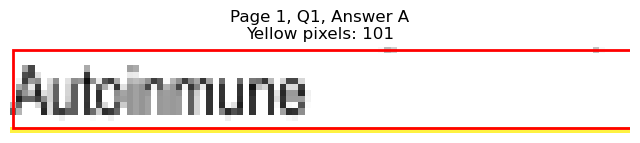

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=101.9, y1=139.9
Page 1, Q1, B: Yellow pixels: 978
Page 1, Q1, B: Total non-white pixels: 1092
Page 1, Q1, B: Yellow percentage: 89.6%


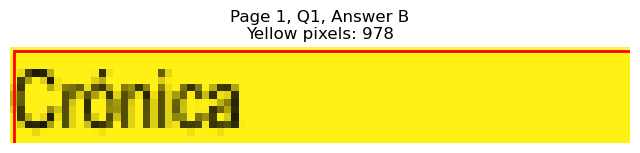

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=356.1, y1=127.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 135
Page 1, Q1, C: Yellow percentage: 0.0%


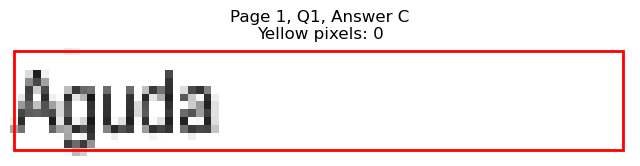

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=368.2, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 195
Page 1, Q1, D: Yellow percentage: 0.0%


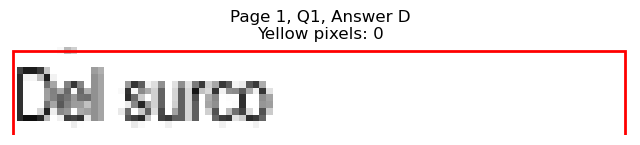


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=121.0, y1=190.4
Page 1, Q2, A: Yellow pixels: 103
Page 1, Q2, A: Total non-white pixels: 366
Page 1, Q2, A: Yellow percentage: 28.1%


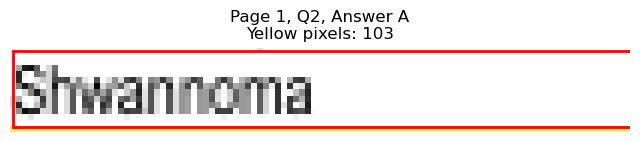

Page 1, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=124.9, y1=203.0
Page 1, Q2, B: Yellow pixels: 1188
Page 1, Q2, B: Total non-white pixels: 1391
Page 1, Q2, B: Yellow percentage: 85.4%


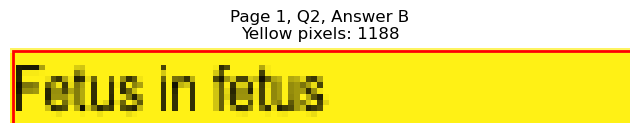

Page 1, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=412.9, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 418
Page 1, Q2, C: Yellow percentage: 0.0%


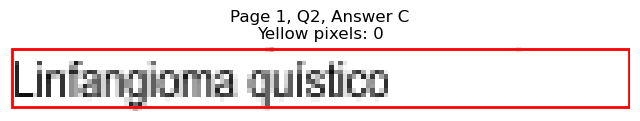

Page 1, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=381.7, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 249
Page 1, Q2, D: Yellow percentage: 0.0%


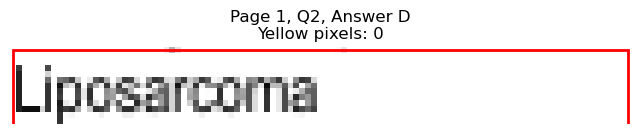


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=103.5, y1=253.5
Page 1, Q3, A: Yellow pixels: 964
Page 1, Q3, A: Total non-white pixels: 1204
Page 1, Q3, A: Yellow percentage: 80.1%


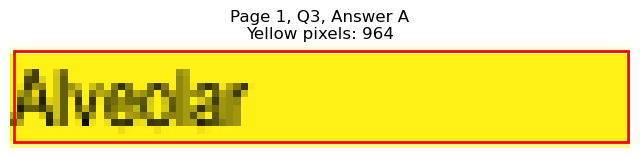

Page 1, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=106.5, y1=266.1
Page 1, Q3, B: Yellow pixels: 89
Page 1, Q3, B: Total non-white pixels: 300
Page 1, Q3, B: Yellow percentage: 29.7%


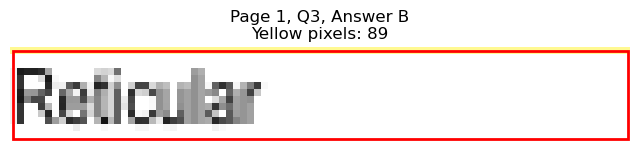

Page 1, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=397.7, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 361
Page 1, Q3, C: Yellow percentage: 0.0%


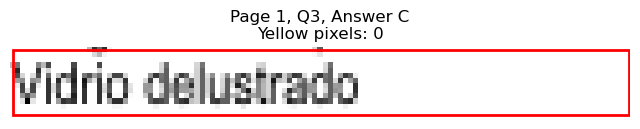

Page 1, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=376.7, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 252
Page 1, Q3, D: Yellow percentage: 0.0%


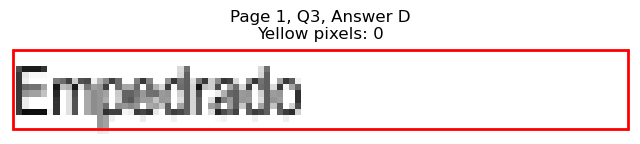


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=157.1, y1=316.7
Page 1, Q4, A: Yellow pixels: 1455
Page 1, Q4, A: Total non-white pixels: 1820
Page 1, Q4, A: Yellow percentage: 79.9%


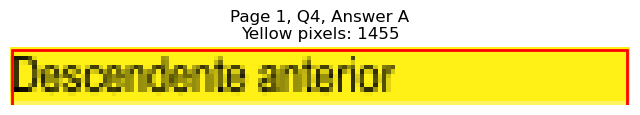

Page 1, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=145.6, y1=329.3
Page 1, Q4, B: Yellow pixels: 128
Page 1, Q4, B: Total non-white pixels: 509
Page 1, Q4, B: Yellow percentage: 25.1%


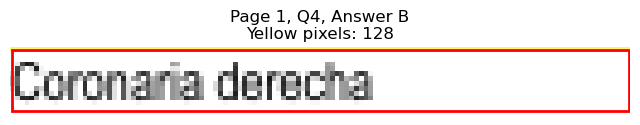

Page 1, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=372.7, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 241
Page 1, Q4, C: Yellow percentage: 0.0%


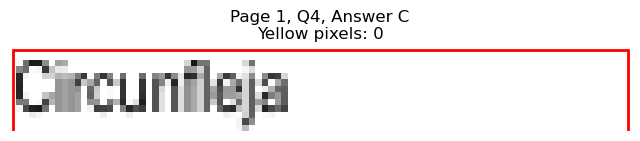

Page 1, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=427.4, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 514
Page 1, Q4, D: Yellow percentage: 0.0%


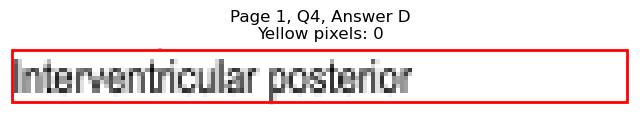


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=272.2, y1=392.4
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 997
Page 1, Q5, A: Yellow percentage: 0.0%


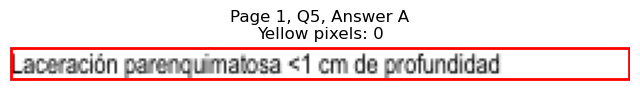

Page 1, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=307.1, y1=405.0
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 1108
Page 1, Q5, B: Yellow percentage: 0.0%


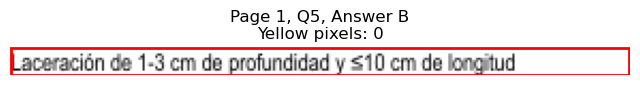

Page 1, Q5 - C: Detected box: x0=68.8, y0=404.9, x1=207.0, y1=417.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 707
Page 1, Q5, C: Yellow percentage: 0.0%


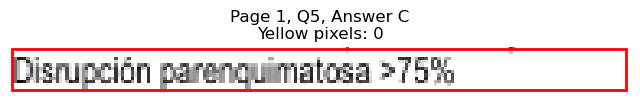

Page 1, Q5 - D: Detected box: x0=68.8, y0=417.6, x1=269.1, y1=430.3
Page 1, Q5, D: Yellow pixels: 2227
Page 1, Q5, D: Total non-white pixels: 3528
Page 1, Q5, D: Yellow percentage: 63.1%


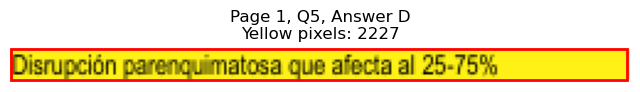


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=113.9, y1=493.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 273
Page 1, Q6, A: Yellow percentage: 0.0%


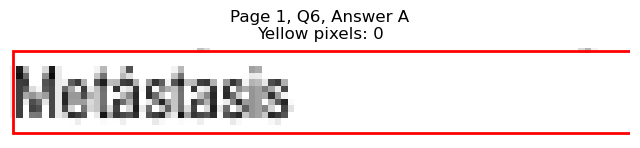

Page 1, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=105.4, y1=506.0
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 190
Page 1, Q6, B: Yellow percentage: 0.0%


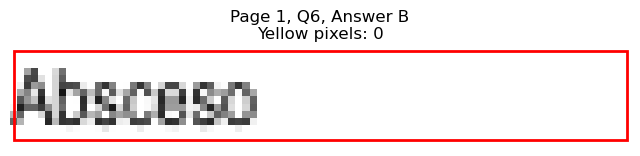

Page 1, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=377.7, y1=493.4
Page 1, Q6, C: Yellow pixels: 1016
Page 1, Q6, C: Total non-white pixels: 1414
Page 1, Q6, C: Yellow percentage: 71.9%


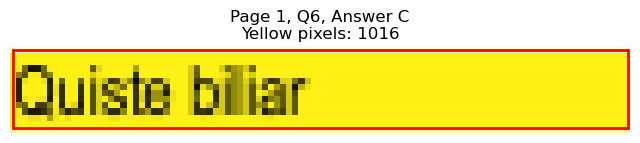

Page 1, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=383.7, y1=506.0
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 383
Page 1, Q6, D: Yellow percentage: 0.0%


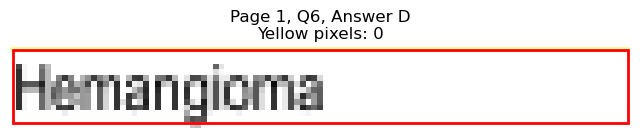


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=79.3, y1=556.4
Page 1, Q7, A: Yellow pixels: 775
Page 1, Q7, A: Total non-white pixels: 868
Page 1, Q7, A: Yellow percentage: 89.3%


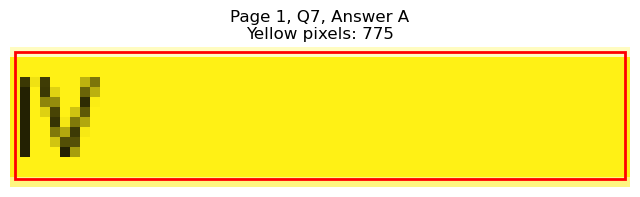

Page 1, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=65.2, y1=569.2
Page 1, Q7, B: Yellow pixels: 60
Page 1, Q7, B: Total non-white pixels: 126
Page 1, Q7, B: Yellow percentage: 47.6%


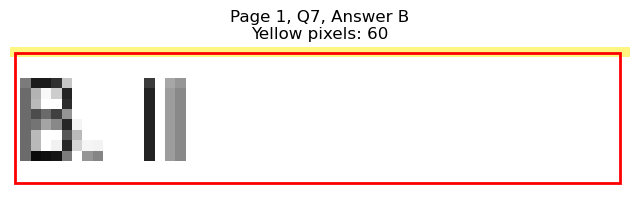

Page 1, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=340.6, y1=556.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 59
Page 1, Q7, C: Yellow percentage: 0.0%


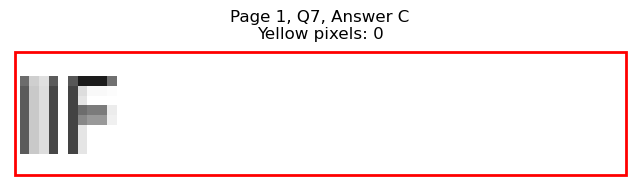

Page 1, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=324.4, y1=569.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 56
Page 1, Q7, D: Yellow percentage: 0.0%


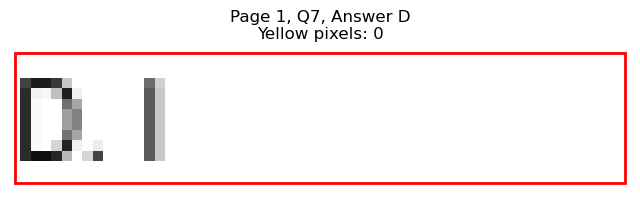


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=137.5, y1=632.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 325
Page 1, Q8, A: Yellow percentage: 0.0%


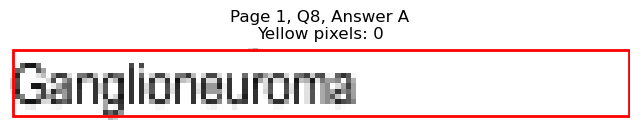

Page 1, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=128.5, y1=644.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 305
Page 1, Q8, B: Yellow percentage: 0.0%


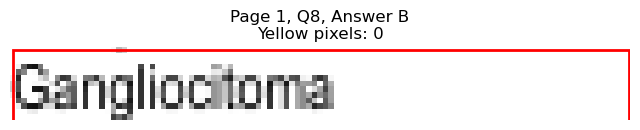

Page 1, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=387.8, y1=632.3
Page 1, Q8, C: Yellow pixels: 111
Page 1, Q8, C: Total non-white pixels: 437
Page 1, Q8, C: Yellow percentage: 25.4%


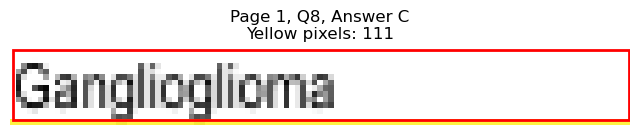

Page 1, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=405.8, y1=644.9
Page 1, Q8, D: Yellow pixels: 1389
Page 1, Q8, D: Total non-white pixels: 1677
Page 1, Q8, D: Yellow percentage: 82.8%


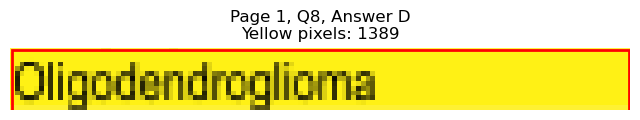


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=173.7, y1=682.7
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 466
Page 1, Q9, A: Yellow percentage: 0.0%


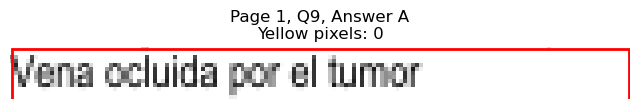

Page 1, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=194.2, y1=695.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 605
Page 1, Q9, B: Yellow percentage: 0.0%


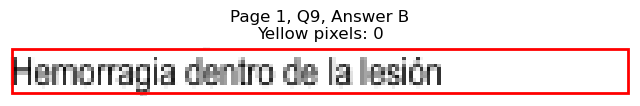

Page 1, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=427.4, y1=682.7
Page 1, Q9, C: Yellow pixels: 1
Page 1, Q9, C: Total non-white pixels: 632
Page 1, Q9, C: Yellow percentage: 0.2%


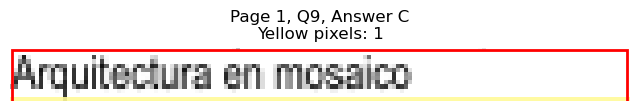

Page 1, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=471.0, y1=695.3
Page 1, Q9, D: Yellow pixels: 1753
Page 1, Q9, D: Total non-white pixels: 2716
Page 1, Q9, D: Yellow percentage: 64.5%


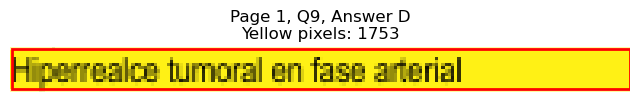


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=147.5, y1=745.8
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 365
Page 1, Q10, A: Yellow percentage: 0.0%


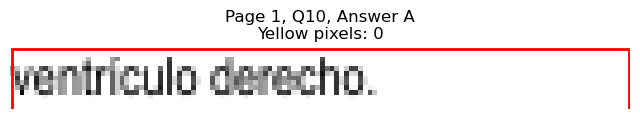

Page 1, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=140.5, y1=758.4
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 329
Page 1, Q10, B: Yellow percentage: 0.0%


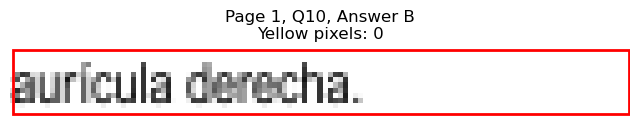

Page 1, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=403.7, y1=745.8
Page 1, Q10, C: Yellow pixels: 1393
Page 1, Q10, C: Total non-white pixels: 1651
Page 1, Q10, C: Yellow percentage: 84.4%


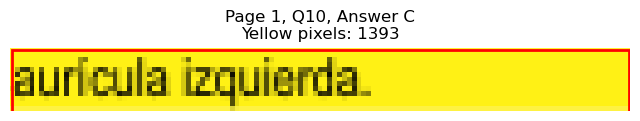

Page 1, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=410.8, y1=758.4
Page 1, Q10, D: Yellow pixels: 134
Page 1, Q10, D: Total non-white pixels: 547
Page 1, Q10, D: Yellow percentage: 24.5%


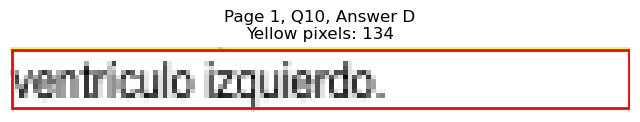


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=234.3, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 854
Page 2, Q1, A: Yellow percentage: 0.0%


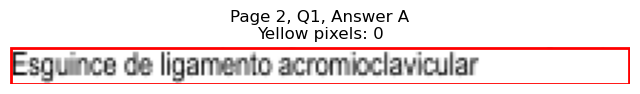

Page 2, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=312.5, y1=127.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 1198
Page 2, Q1, B: Yellow percentage: 0.0%


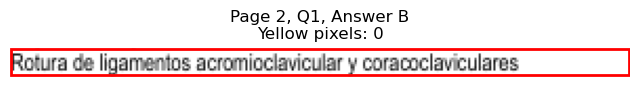

Page 2, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=365.2, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 1460
Page 2, Q1, C: Yellow percentage: 0.0%


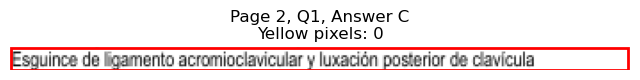

Page 2, Q1 - D: Detected box: x0=68.8, y0=139.9, x1=349.6, y1=152.6
Page 2, Q1, D: Yellow pixels: 3176
Page 2, Q1, D: Total non-white pixels: 4648
Page 2, Q1, D: Yellow percentage: 68.3%


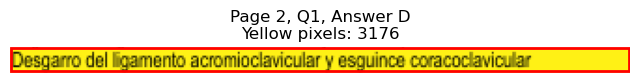


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=180.1, y1=203.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 701
Page 2, Q2, A: Yellow percentage: 0.0%


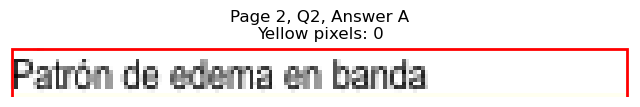

Page 2, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=131.1, y1=215.6
Page 2, Q2, B: Yellow pixels: 1250
Page 2, Q2, B: Total non-white pixels: 1596
Page 2, Q2, B: Yellow percentage: 78.3%


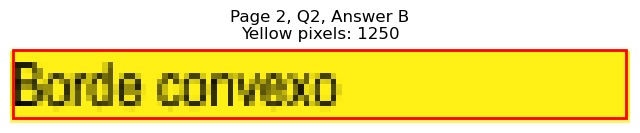

Page 2, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=418.4, y1=203.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 468
Page 2, Q2, C: Yellow percentage: 0.0%


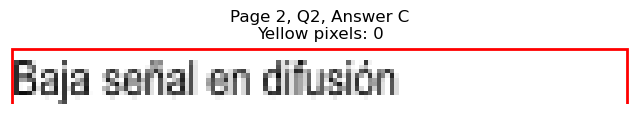

Page 2, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=447.5, y1=215.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 545
Page 2, Q2, D: Yellow percentage: 0.0%


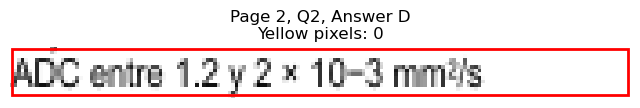


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=179.7, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 515
Page 2, Q3, A: Yellow percentage: 0.0%


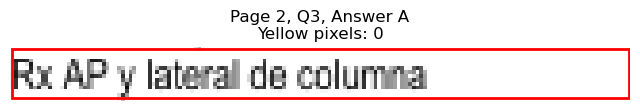

Page 2, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=166.6, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 479
Page 2, Q3, B: Yellow percentage: 0.0%


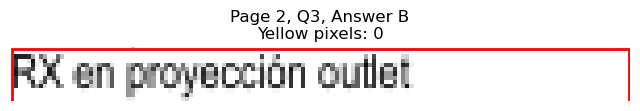

Page 2, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=373.6, y1=266.1
Page 2, Q3, C: Yellow pixels: 1096
Page 2, Q3, C: Total non-white pixels: 1358
Page 2, Q3, C: Yellow percentage: 80.7%


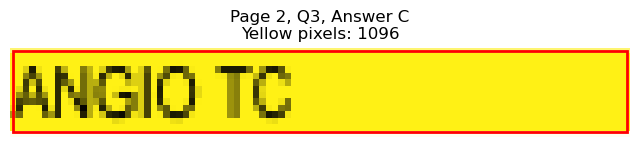

Page 2, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=350.6, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 194
Page 2, Q3, D: Yellow percentage: 0.0%


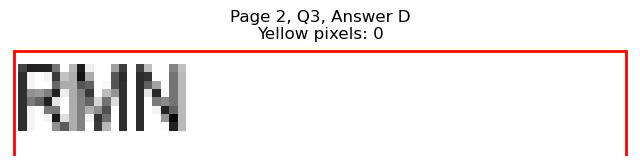


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=121.9, y1=329.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 267
Page 2, Q4, A: Yellow percentage: 0.0%


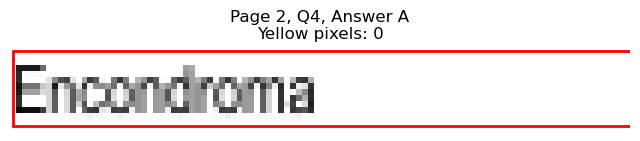

Page 2, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=137.1, y1=341.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 358
Page 2, Q4, B: Yellow percentage: 0.0%


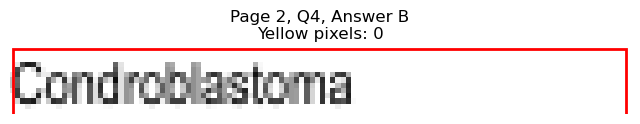

Page 2, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=394.3, y1=329.3
Page 2, Q4, C: Yellow pixels: 1161
Page 2, Q4, C: Total non-white pixels: 1652
Page 2, Q4, C: Yellow percentage: 70.3%


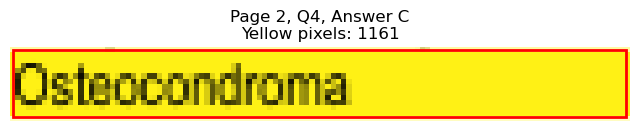

Page 2, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=424.3, y1=341.9
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 637
Page 2, Q4, D: Yellow percentage: 0.0%


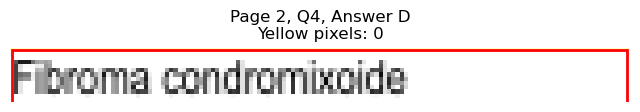


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=245.3, y1=379.8
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 934
Page 2, Q5, A: Yellow percentage: 0.0%


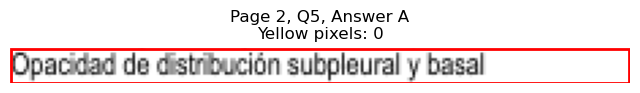

Page 2, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=172.7, y1=392.4
Page 2, Q5, B: Yellow pixels: 155
Page 2, Q5, B: Total non-white pixels: 667
Page 2, Q5, B: Yellow percentage: 23.2%


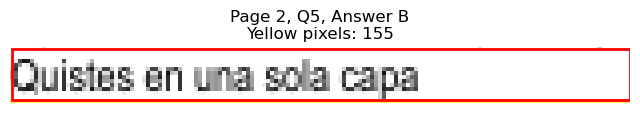

Page 2, Q5 - C: Detected box: x0=68.8, y0=392.3, x1=311.1, y1=405.0
Page 2, Q5, C: Yellow pixels: 2912
Page 2, Q5, C: Total non-white pixels: 3822
Page 2, Q5, C: Yellow percentage: 76.2%


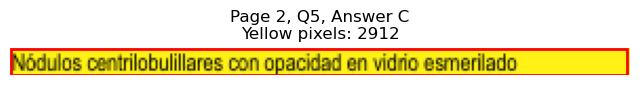

Page 2, Q5 - D: Detected box: x0=68.8, y0=404.9, x1=198.3, y1=417.6
Page 2, Q5, D: Yellow pixels: 180
Page 2, Q5, D: Total non-white pixels: 837
Page 2, Q5, D: Yellow percentage: 21.5%


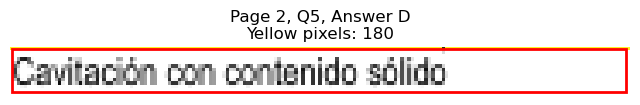


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=119.4, y1=455.5
Page 2, Q6, A: Yellow pixels: 102
Page 2, Q6, A: Total non-white pixels: 403
Page 2, Q6, A: Yellow percentage: 25.3%


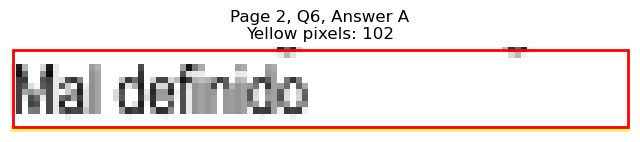

Page 2, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=149.1, y1=468.1
Page 2, Q6, B: Yellow pixels: 1395
Page 2, Q6, B: Total non-white pixels: 1848
Page 2, Q6, B: Yellow percentage: 75.5%


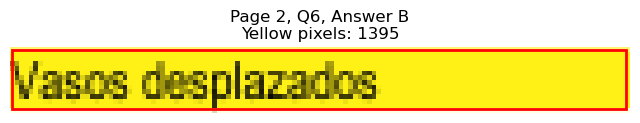

Page 2, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=389.7, y1=455.5
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 316
Page 2, Q6, C: Yellow percentage: 0.0%


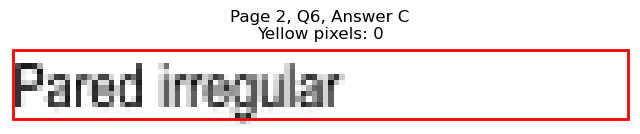

Page 2, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=362.7, y1=468.1
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 183
Page 2, Q6, D: Yellow percentage: 0.0%


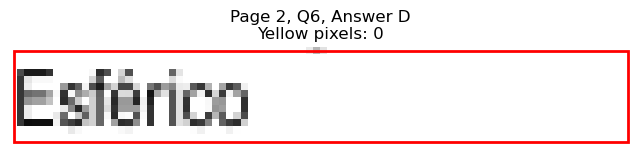


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=276.4, y1=506.0
Page 2, Q7, A: Yellow pixels: 213
Page 2, Q7, A: Total non-white pixels: 1502
Page 2, Q7, A: Yellow percentage: 14.2%


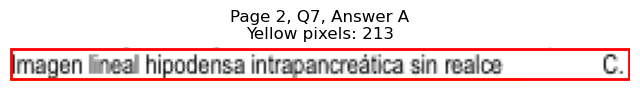

Page 2, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=279.5, y1=518.6
Page 2, Q7, B: Yellow pixels: 1927
Page 2, Q7, B: Total non-white pixels: 3049
Page 2, Q7, B: Yellow percentage: 63.2%


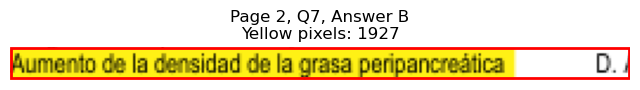

Page 2, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=493.2, y1=506.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 862
Page 2, Q7, C: Yellow percentage: 0.0%


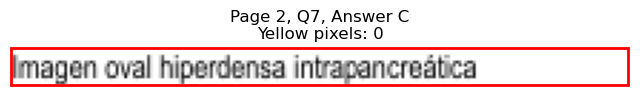

Page 2, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=465.4, y1=518.6
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 691
Page 2, Q7, D: Yellow percentage: 0.0%


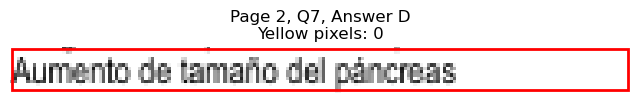


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=197.2, y1=581.8
Page 2, Q8, A: Yellow pixels: 1826
Page 2, Q8, A: Total non-white pixels: 2340
Page 2, Q8, A: Yellow percentage: 78.0%


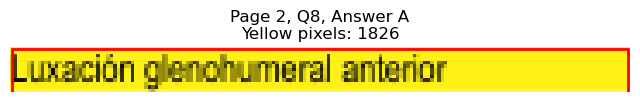

Page 2, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=152.5, y1=594.4
Page 2, Q8, B: Yellow pixels: 134
Page 2, Q8, B: Total non-white pixels: 533
Page 2, Q8, B: Yellow percentage: 25.1%


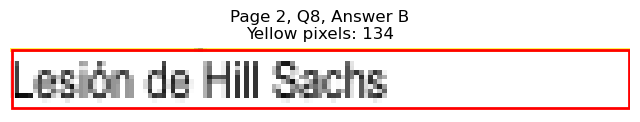

Page 2, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=402.8, y1=581.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 379
Page 2, Q8, C: Yellow percentage: 0.0%


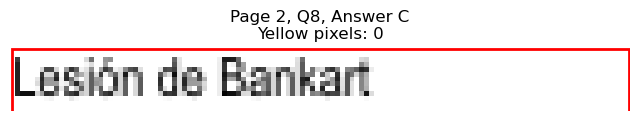

Page 2, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=416.8, y1=594.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 421
Page 2, Q8, D: Yellow percentage: 0.0%


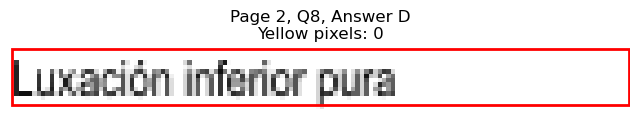


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=150.5, y1=632.3
Page 2, Q9, A: Yellow pixels: 133
Page 2, Q9, A: Total non-white pixels: 559
Page 2, Q9, A: Yellow percentage: 23.8%


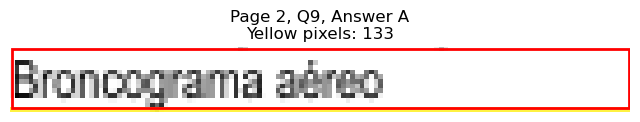

Page 2, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=147.0, y1=644.9
Page 2, Q9, B: Yellow pixels: 1371
Page 2, Q9, B: Total non-white pixels: 1690
Page 2, Q9, B: Yellow percentage: 81.1%


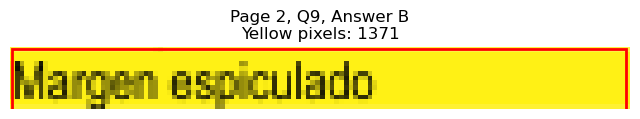

Page 2, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=455.9, y1=632.3
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 654
Page 2, Q9, C: Yellow percentage: 0.0%


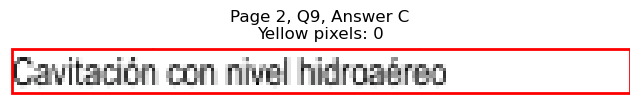

Page 2, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=441.9, y1=644.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 614
Page 2, Q9, D: Yellow percentage: 0.0%


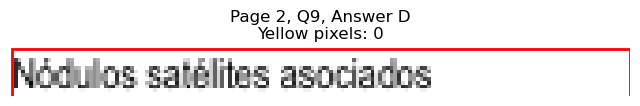


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=79.3, y1=708.0
Page 2, Q10, A: Yellow pixels: 775
Page 2, Q10, A: Total non-white pixels: 806
Page 2, Q10, A: Yellow percentage: 96.2%


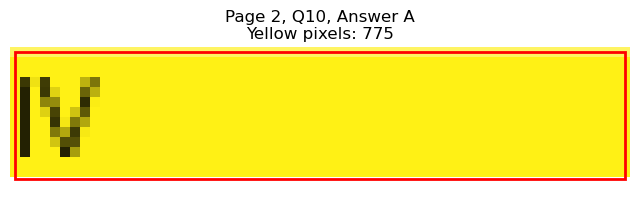

Page 2, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=65.2, y1=720.6
Page 2, Q10, B: Yellow pixels: 60
Page 2, Q10, B: Total non-white pixels: 110
Page 2, Q10, B: Yellow percentage: 54.5%


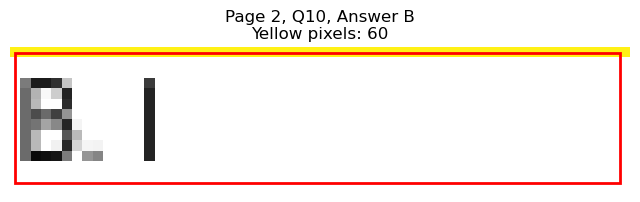

Page 2, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=324.4, y1=708.0
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 68
Page 2, Q10, C: Yellow percentage: 0.0%


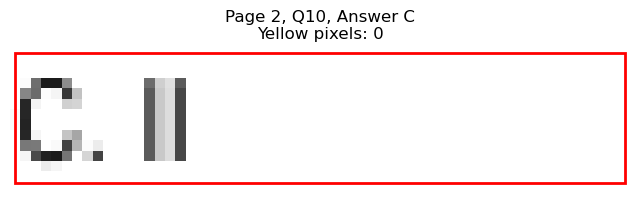

Page 2, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=324.4, y1=720.6
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 69
Page 2, Q10, D: Yellow percentage: 0.0%


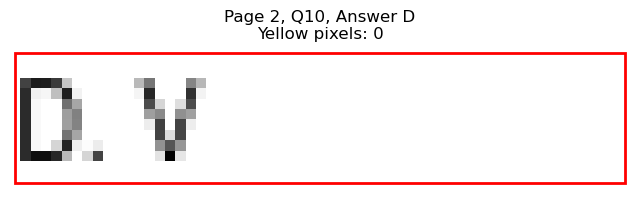


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=143.1, y1=114.7
Page 3, Q1, A: Yellow pixels: 1
Page 3, Q1, A: Total non-white pixels: 462
Page 3, Q1, A: Yellow percentage: 0.2%


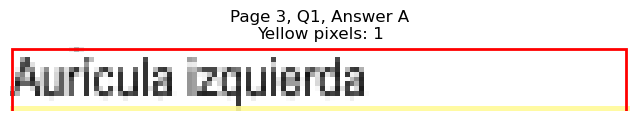

Page 3, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=146.5, y1=127.3
Page 3, Q1, B: Yellow pixels: 1252
Page 3, Q1, B: Total non-white pixels: 1806
Page 3, Q1, B: Yellow percentage: 69.3%


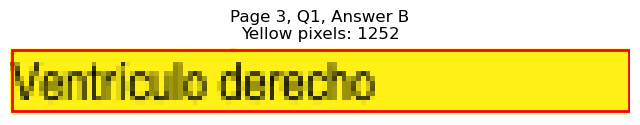

Page 3, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=409.7, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 414
Page 3, Q1, C: Yellow percentage: 0.0%


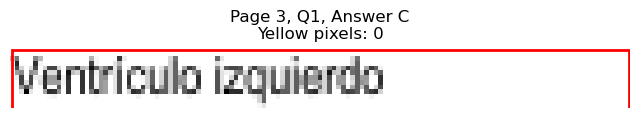

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=398.2, y1=127.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 341
Page 3, Q1, D: Yellow percentage: 0.0%


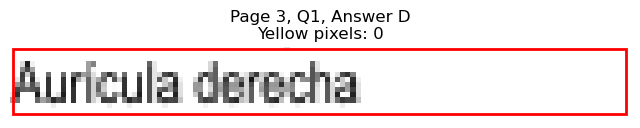


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=228.8, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 790
Page 3, Q2, A: Yellow percentage: 0.0%


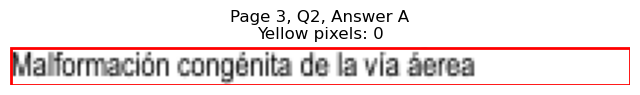

Page 3, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=154.1, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 436
Page 3, Q2, B: Yellow percentage: 0.0%


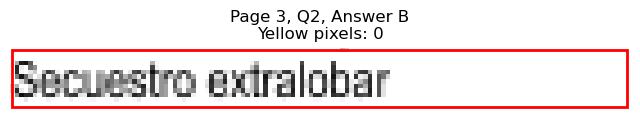

Page 3, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=469.5, y1=177.8
Page 3, Q2, C: Yellow pixels: 1
Page 3, Q2, C: Total non-white pixels: 942
Page 3, Q2, C: Yellow percentage: 0.1%


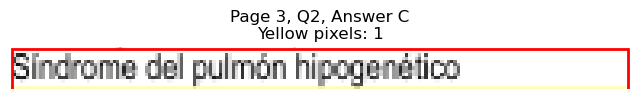

Page 3, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=410.8, y1=190.4
Page 3, Q2, D: Yellow pixels: 1263
Page 3, Q2, D: Total non-white pixels: 1876
Page 3, Q2, D: Yellow percentage: 67.3%


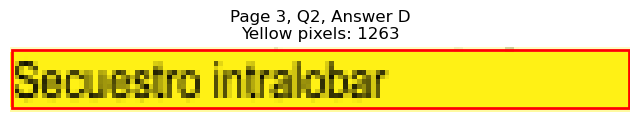


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=112.9, y1=253.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 249
Page 3, Q3, A: Yellow percentage: 0.0%


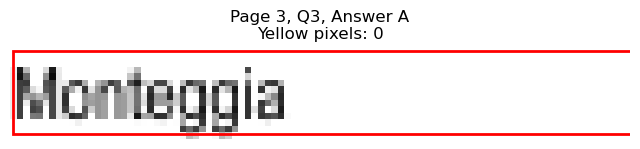

Page 3, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=107.9, y1=266.1
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 203
Page 3, Q3, B: Yellow percentage: 0.0%


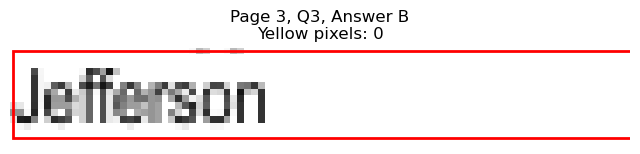

Page 3, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=365.2, y1=253.5
Page 3, Q3, C: Yellow pixels: 1023
Page 3, Q3, C: Total non-white pixels: 1246
Page 3, Q3, C: Yellow percentage: 82.1%


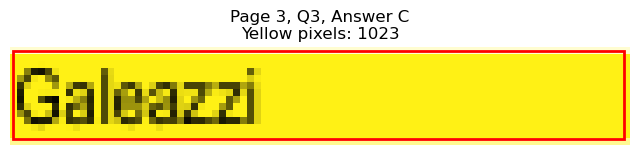

Page 3, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=351.2, y1=266.1
Page 3, Q3, D: Yellow pixels: 75
Page 3, Q3, D: Total non-white pixels: 191
Page 3, Q3, D: Yellow percentage: 39.3%


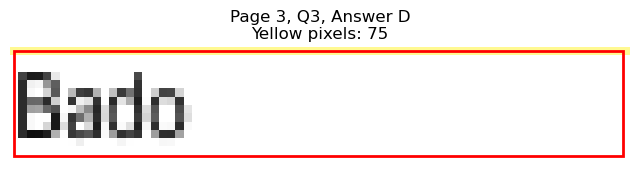


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=126.5, y1=329.3
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 279
Page 3, Q4, A: Yellow percentage: 0.0%


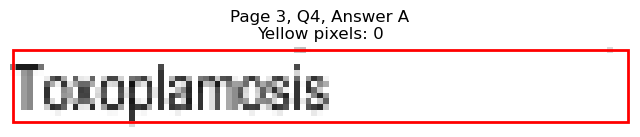

Page 3, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=176.1, y1=341.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 559
Page 3, Q4, B: Yellow percentage: 0.0%


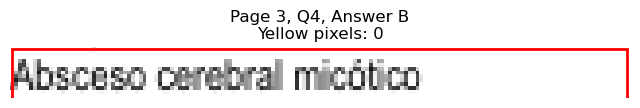

Page 3, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=380.7, y1=329.3
Page 3, Q4, C: Yellow pixels: 104
Page 3, Q4, C: Total non-white pixels: 391
Page 3, Q4, C: Yellow percentage: 26.6%


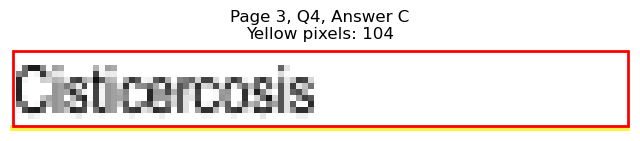

Page 3, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=433.9, y1=341.9
Page 3, Q4, D: Yellow pixels: 1620
Page 3, Q4, D: Total non-white pixels: 2041
Page 3, Q4, D: Yellow percentage: 79.4%


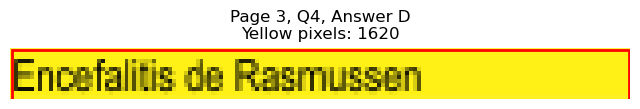


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=146.1, y1=405.0
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 403
Page 3, Q5, A: Yellow percentage: 0.0%


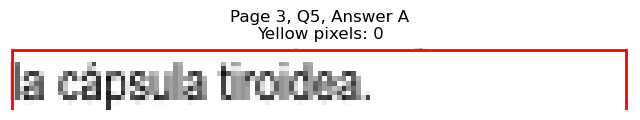

Page 3, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=154.6, y1=417.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 419
Page 3, Q5, B: Yellow percentage: 0.0%


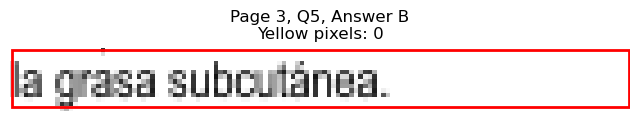

Page 3, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=468.0, y1=405.0
Page 3, Q5, C: Yellow pixels: 1972
Page 3, Q5, C: Total non-white pixels: 2483
Page 3, Q5, C: Yellow percentage: 79.4%


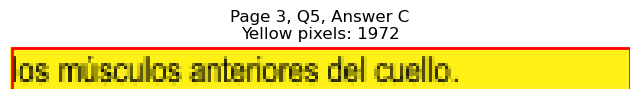

Page 3, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=371.2, y1=417.6
Page 3, Q5, D: Yellow pixels: 95
Page 3, Q5, D: Total non-white pixels: 293
Page 3, Q5, D: Yellow percentage: 32.4%


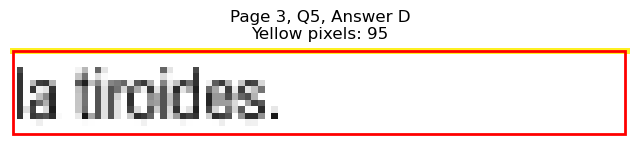


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=117.5, y1=480.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 265
Page 3, Q6, A: Yellow percentage: 0.0%


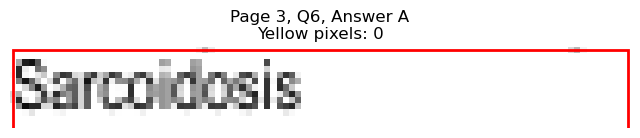

Page 3, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=113.9, y1=493.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 268
Page 3, Q6, B: Yellow percentage: 0.0%


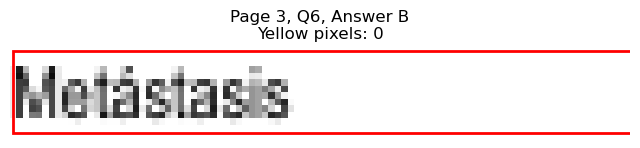

Page 3, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=408.8, y1=480.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 403
Page 3, Q6, C: Yellow percentage: 0.0%


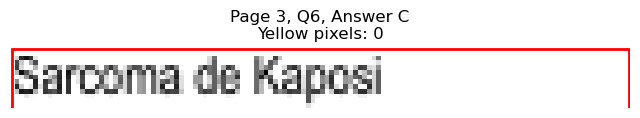

Page 3, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=390.2, y1=493.4
Page 3, Q6, D: Yellow pixels: 1108
Page 3, Q6, D: Total non-white pixels: 1596
Page 3, Q6, D: Yellow percentage: 69.4%


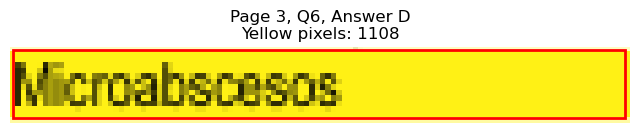


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=96.9, y1=543.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 114
Page 3, Q7, A: Yellow percentage: 0.0%


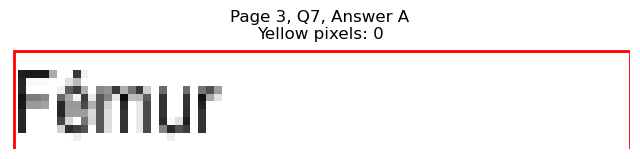

Page 3, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=110.9, y1=556.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 208
Page 3, Q7, B: Yellow percentage: 0.0%


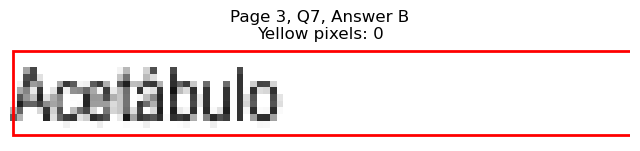

Page 3, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=352.6, y1=543.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 191
Page 3, Q7, C: Yellow percentage: 0.0%


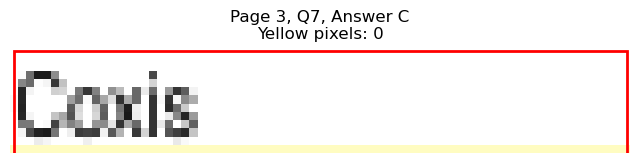

Page 3, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=367.6, y1=556.4
Page 3, Q7, D: Yellow pixels: 1041
Page 3, Q7, D: Total non-white pixels: 1274
Page 3, Q7, D: Yellow percentage: 81.7%


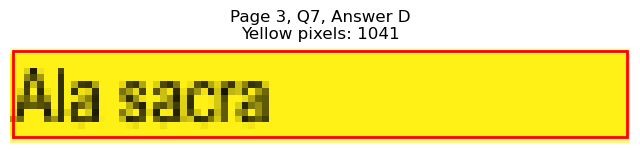


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=200.2, y1=594.4
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 627
Page 3, Q8, A: Yellow percentage: 0.0%


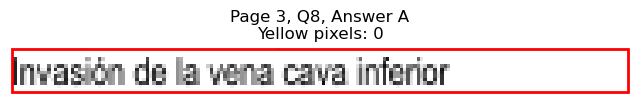

Page 3, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=369.3, y1=607.0
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 1809
Page 3, Q8, B: Yellow percentage: 0.0%


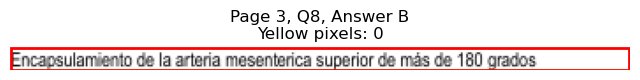

Page 3, Q8 - C: Detected box: x0=68.8, y0=606.9, x1=369.8, y1=619.6
Page 3, Q8, C: Yellow pixels: 3415
Page 3, Q8, C: Total non-white pixels: 4928
Page 3, Q8, C: Yellow percentage: 69.3%


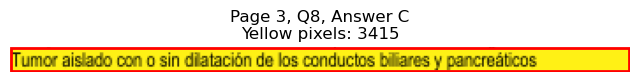

Page 3, Q8 - D: Detected box: x0=68.8, y0=619.6, x1=310.5, y1=632.3
Page 3, Q8, D: Yellow pixels: 292
Page 3, Q8, D: Total non-white pixels: 1468
Page 3, Q8, D: Yellow percentage: 19.9%


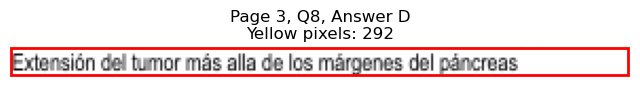


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=118.5, y1=670.1
Page 3, Q9, A: Yellow pixels: 1125
Page 3, Q9, A: Total non-white pixels: 1414
Page 3, Q9, A: Yellow percentage: 79.6%


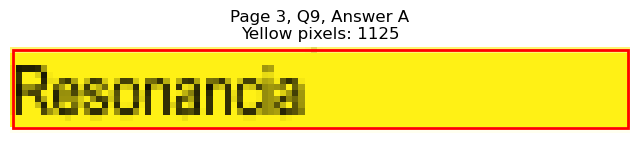

Page 3, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=117.5, y1=682.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 382
Page 3, Q9, B: Yellow percentage: 0.0%


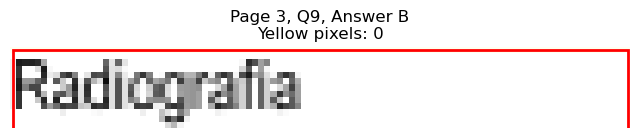

Page 3, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=368.7, y1=670.1
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 221
Page 3, Q9, C: Yellow percentage: 0.0%


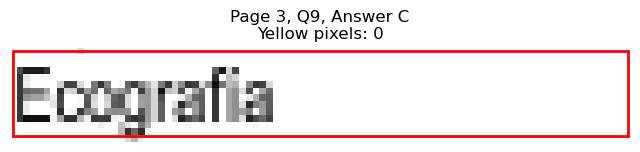

Page 3, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=376.1, y1=682.7
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 243
Page 3, Q9, D: Yellow percentage: 0.0%


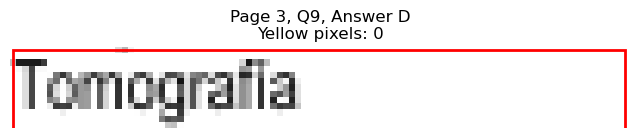


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=85.3, y1=733.2
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 84
Page 3, Q10, A: Yellow percentage: 0.0%


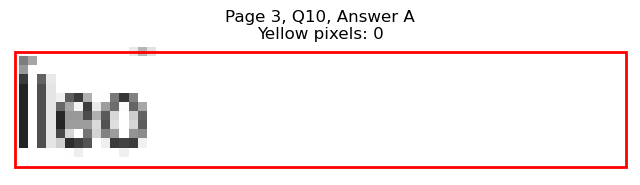

Page 3, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=157.1, y1=745.8
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 432
Page 3, Q10, B: Yellow percentage: 0.0%


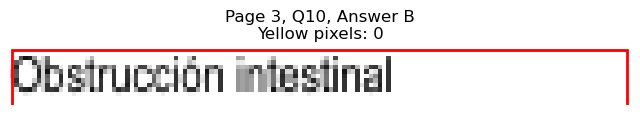

Page 3, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=377.7, y1=733.2
Page 3, Q10, C: Yellow pixels: 101
Page 3, Q10, C: Total non-white pixels: 353
Page 3, Q10, C: Yellow percentage: 28.6%


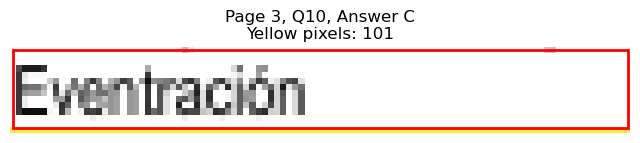

Page 3, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=396.8, y1=745.8
Page 3, Q10, D: Yellow pixels: 1269
Page 3, Q10, D: Total non-white pixels: 1560
Page 3, Q10, D: Yellow percentage: 81.3%


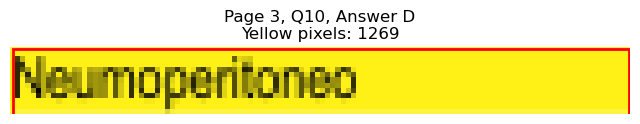


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=76.8, y1=114.7
Page 4, Q1, A: Yellow pixels: 745
Page 4, Q1, A: Total non-white pixels: 767
Page 4, Q1, A: Yellow percentage: 97.1%


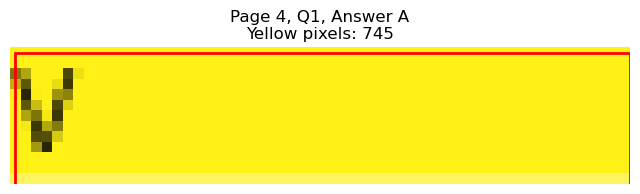

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=65.2, y1=127.3
Page 4, Q1, B: Yellow pixels: 60
Page 4, Q1, B: Total non-white pixels: 110
Page 4, Q1, B: Yellow percentage: 54.5%


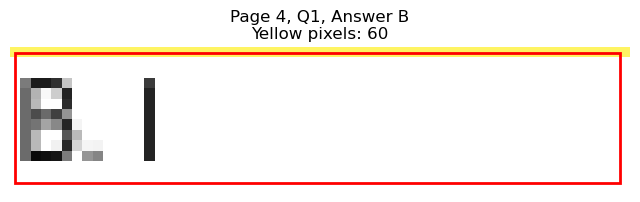

Page 4, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=337.6, y1=114.7
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 48
Page 4, Q1, C: Yellow percentage: 0.0%


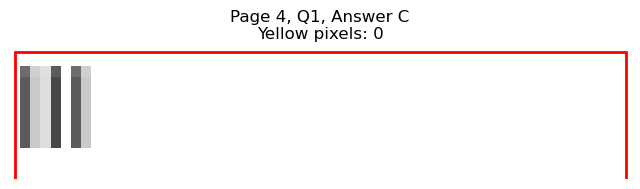

Page 4, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=338.6, y1=127.3
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 42
Page 4, Q1, D: Yellow percentage: 0.0%


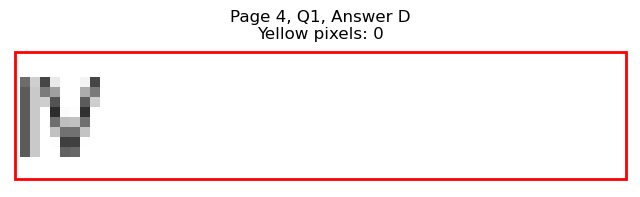


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=103.5, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 196
Page 4, Q2, A: Yellow percentage: 0.0%


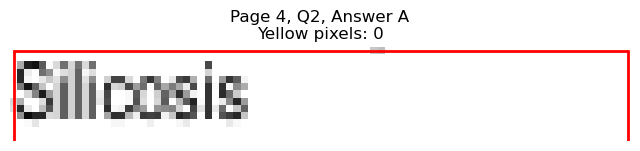

Page 4, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=118.5, y1=190.4
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 272
Page 4, Q2, B: Yellow percentage: 0.0%


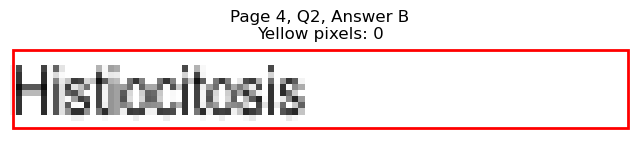

Page 4, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=397.7, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 481
Page 4, Q2, C: Yellow percentage: 0.0%


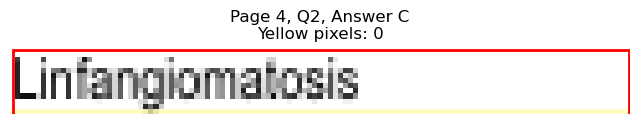

Page 4, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=381.2, y1=190.4
Page 4, Q2, D: Yellow pixels: 1050
Page 4, Q2, D: Total non-white pixels: 1470
Page 4, Q2, D: Yellow percentage: 71.4%


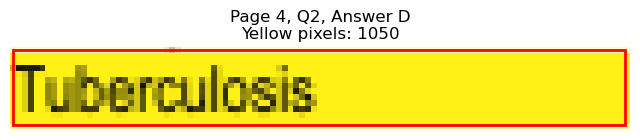


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=85.8, y1=240.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 97
Page 4, Q3, A: Yellow percentage: 0.0%


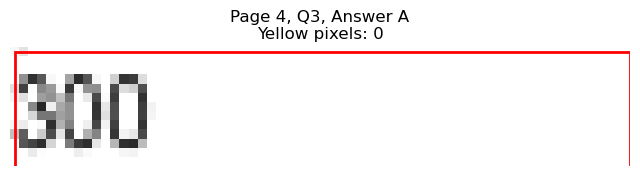

Page 4, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=85.8, y1=253.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 82
Page 4, Q3, B: Yellow percentage: 0.0%


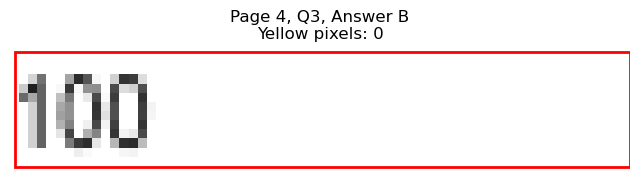

Page 4, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=345.1, y1=240.9
Page 4, Q3, C: Yellow pixels: 837
Page 4, Q3, C: Total non-white pixels: 897
Page 4, Q3, C: Yellow percentage: 93.3%


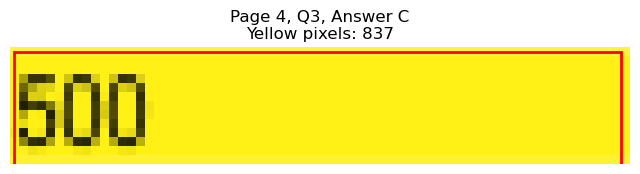

Page 4, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=340.1, y1=253.5
Page 4, Q3, D: Yellow pixels: 64
Page 4, Q3, D: Total non-white pixels: 124
Page 4, Q3, D: Yellow percentage: 51.6%


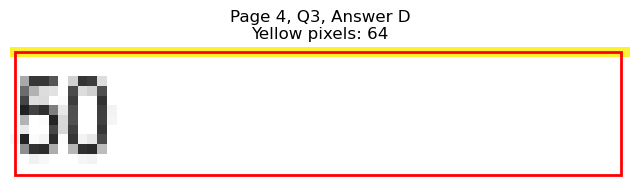


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=142.5, y1=304.1
Page 4, Q4, A: Yellow pixels: 125
Page 4, Q4, A: Total non-white pixels: 471
Page 4, Q4, A: Yellow percentage: 26.5%


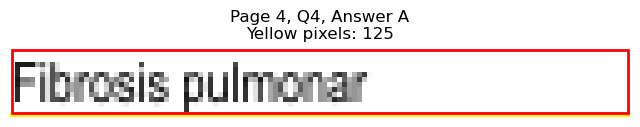

Page 4, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=155.1, y1=316.7
Page 4, Q4, B: Yellow pixels: 1464
Page 4, Q4, B: Total non-white pixels: 1794
Page 4, Q4, B: Yellow percentage: 81.6%


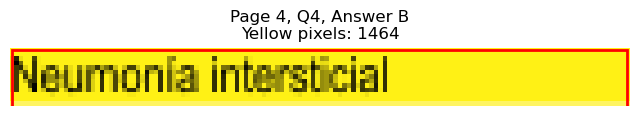

Page 4, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=391.7, y1=304.1
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 328
Page 4, Q4, C: Yellow percentage: 0.0%


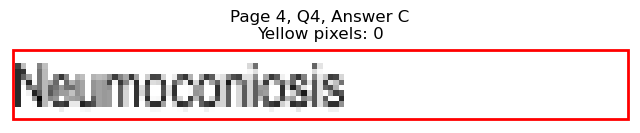

Page 4, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=430.4, y1=316.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 513
Page 4, Q4, D: Yellow percentage: 0.0%


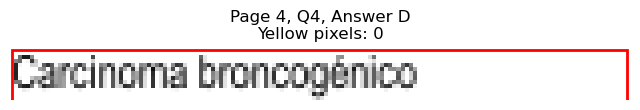


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=121.9, y1=367.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 268
Page 4, Q5, A: Yellow percentage: 0.0%


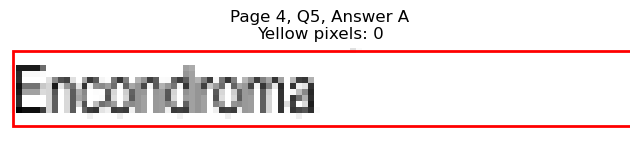

Page 4, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=135.0, y1=379.8
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 324
Page 4, Q5, B: Yellow percentage: 0.0%


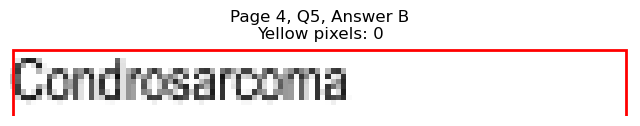

Page 4, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=396.3, y1=367.2
Page 4, Q5, C: Yellow pixels: 1267
Page 4, Q5, C: Total non-white pixels: 1680
Page 4, Q5, C: Yellow percentage: 75.4%


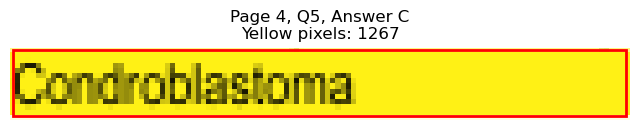

Page 4, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=394.3, y1=379.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 449
Page 4, Q5, D: Yellow percentage: 0.0%


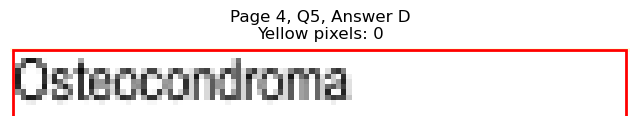


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=114.4, y1=455.5
Page 4, Q6, A: Yellow pixels: 97
Page 4, Q6, A: Total non-white pixels: 333
Page 4, Q6, A: Yellow percentage: 29.1%


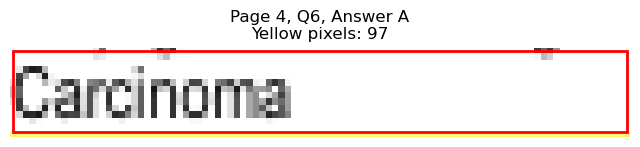

Page 4, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=109.5, y1=468.1
Page 4, Q6, B: Yellow pixels: 1035
Page 4, Q6, B: Total non-white pixels: 1288
Page 4, Q6, B: Yellow percentage: 80.4%


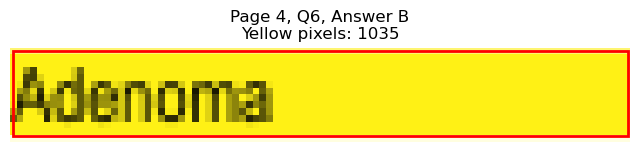

Page 4, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=364.6, y1=455.5
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 180
Page 4, Q6, C: Yellow percentage: 0.0%


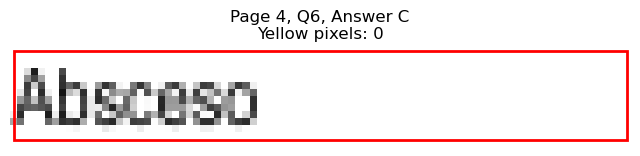

Page 4, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=373.1, y1=468.1
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 248
Page 4, Q6, D: Yellow percentage: 0.0%


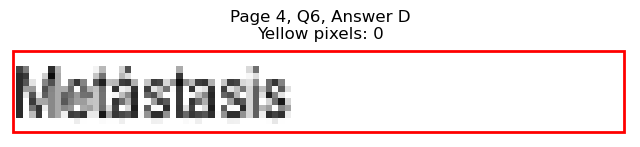


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=154.1, y1=518.6
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 469
Page 4, Q7, A: Yellow percentage: 0.0%


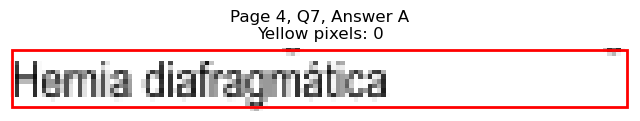

Page 4, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=119.9, y1=531.2
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 274
Page 4, Q7, B: Yellow percentage: 0.0%


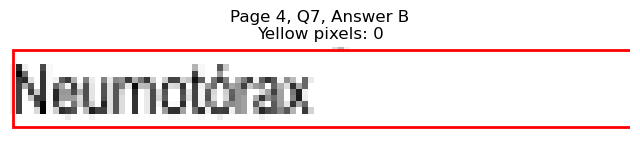

Page 4, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=446.9, y1=518.6
Page 4, Q7, C: Yellow pixels: 1736
Page 4, Q7, C: Total non-white pixels: 2380
Page 4, Q7, C: Yellow percentage: 72.9%


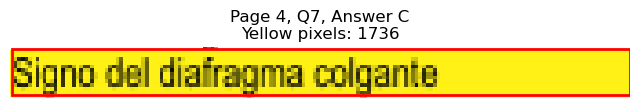

Page 4, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=447.4, y1=531.2
Page 4, Q7, D: Yellow pixels: 166
Page 4, Q7, D: Total non-white pixels: 811
Page 4, Q7, D: Yellow percentage: 20.5%


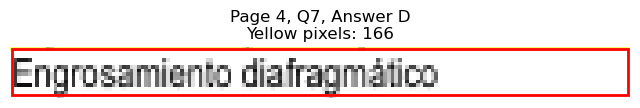


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=102.4, y1=594.4
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 186
Page 4, Q8, A: Yellow percentage: 0.0%


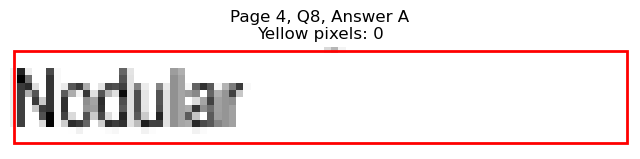

Page 4, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=109.9, y1=607.0
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 182
Page 4, Q8, B: Yellow percentage: 0.0%


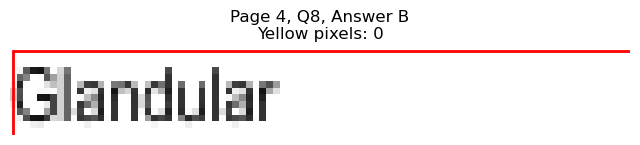

Page 4, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=371.2, y1=594.4
Page 4, Q8, C: Yellow pixels: 950
Page 4, Q8, C: Total non-white pixels: 1330
Page 4, Q8, C: Yellow percentage: 71.4%


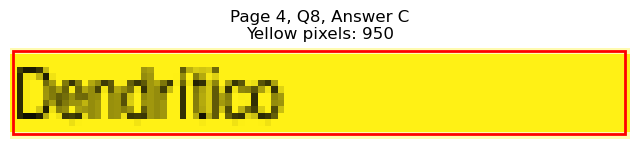

Page 4, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=362.7, y1=607.0
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 244
Page 4, Q8, D: Yellow percentage: 0.0%


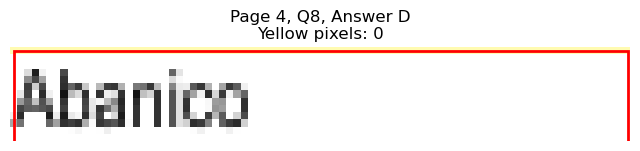


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=98.9, y1=657.5
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 137
Page 4, Q9, A: Yellow percentage: 0.0%


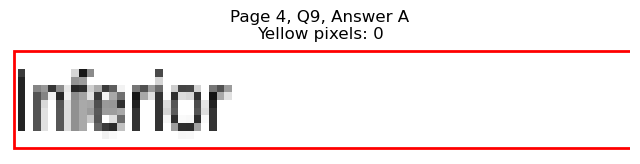

Page 4, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=95.4, y1=670.1
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 156
Page 4, Q9, B: Yellow percentage: 0.0%


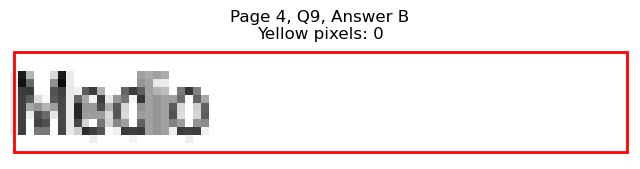

Page 4, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=359.7, y1=657.5
Page 4, Q9, C: Yellow pixels: 83
Page 4, Q9, C: Total non-white pixels: 241
Page 4, Q9, C: Yellow percentage: 34.4%


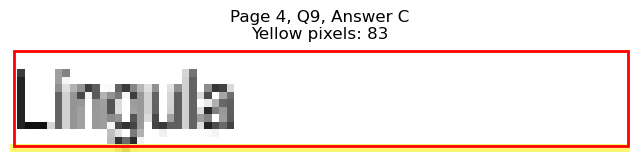

Page 4, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=364.1, y1=670.1
Page 4, Q9, D: Yellow pixels: 1015
Page 4, Q9, D: Total non-white pixels: 1232
Page 4, Q9, D: Yellow percentage: 82.4%


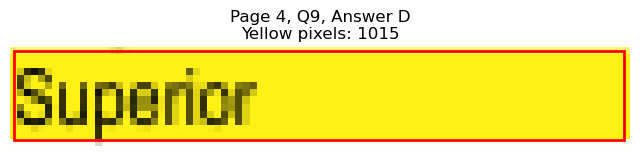


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=177.1, y1=733.2
Page 4, Q10, A: Yellow pixels: 160
Page 4, Q10, A: Total non-white pixels: 704
Page 4, Q10, A: Yellow percentage: 22.7%


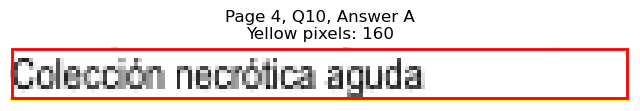

Page 4, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=153.0, y1=745.8
Page 4, Q10, B: Yellow pixels: 1456
Page 4, Q10, B: Total non-white pixels: 1768
Page 4, Q10, B: Yellow percentage: 82.4%


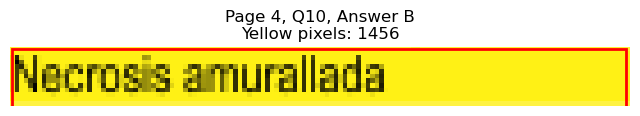

Page 4, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=384.8, y1=733.2
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 312
Page 4, Q10, C: Yellow percentage: 0.0%


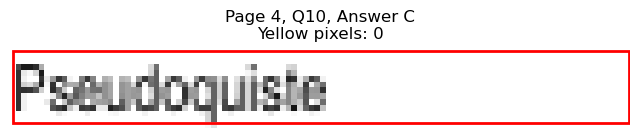

Page 4, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=362.2, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 182
Page 4, Q10, D: Yellow percentage: 0.0%


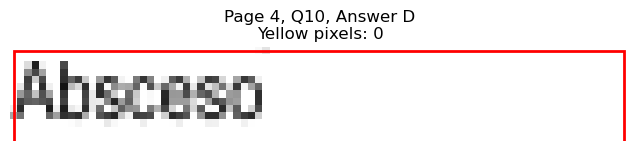


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=103.9, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 174
Page 5, Q1, A: Yellow percentage: 0.0%


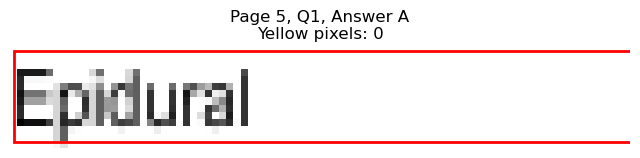

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=106.9, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 184
Page 5, Q1, B: Yellow percentage: 0.0%


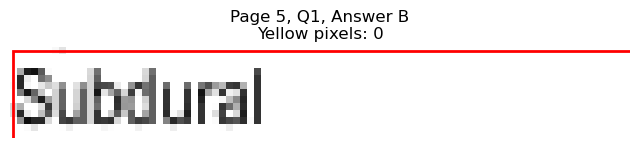

Page 5, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=373.1, y1=127.3
Page 5, Q1, C: Yellow pixels: 97
Page 5, Q1, C: Total non-white pixels: 326
Page 5, Q1, C: Yellow percentage: 29.8%


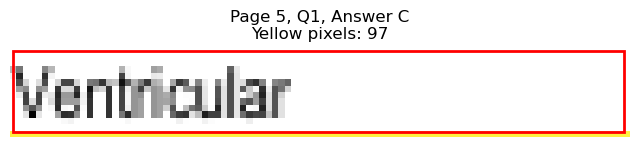

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=380.7, y1=139.9
Page 5, Q1, D: Yellow pixels: 1117
Page 5, Q1, D: Total non-white pixels: 1352
Page 5, Q1, D: Yellow percentage: 82.6%


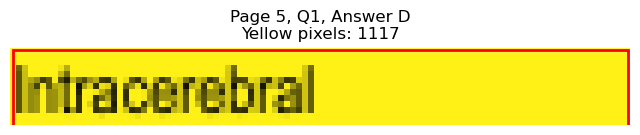


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=150.5, y1=203.0
Page 5, Q2, A: Yellow pixels: 1380
Page 5, Q2, A: Total non-white pixels: 1729
Page 5, Q2, A: Yellow percentage: 79.8%


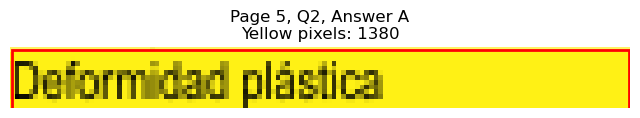

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=115.5, y1=215.6
Page 5, Q2, B: Yellow pixels: 97
Page 5, Q2, B: Total non-white pixels: 327
Page 5, Q2, B: Yellow percentage: 29.7%


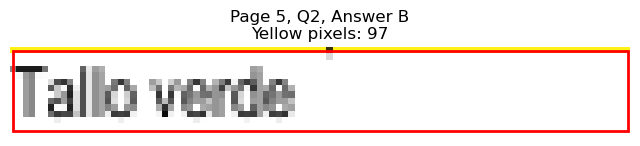

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=369.2, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 190
Page 5, Q2, C: Yellow percentage: 0.0%


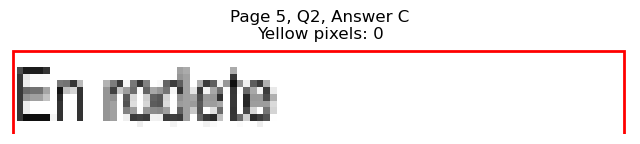

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=374.2, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 268
Page 5, Q2, D: Yellow percentage: 0.0%


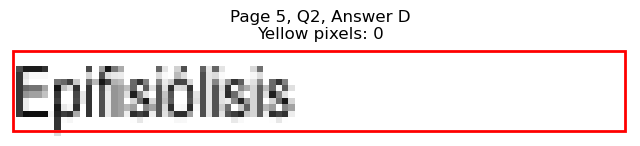


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=88.3, y1=266.1
Page 5, Q3, A: Yellow pixels: 863
Page 5, Q3, A: Total non-white pixels: 994
Page 5, Q3, A: Yellow percentage: 86.8%


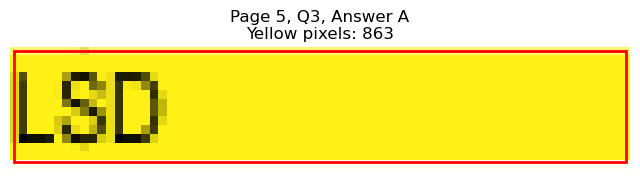

Page 5, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=83.3, y1=278.7
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 139
Page 5, Q3, B: Yellow percentage: 0.0%


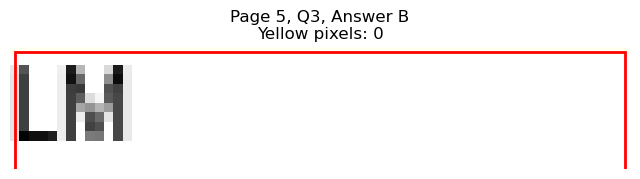

Page 5, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=344.1, y1=266.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 64
Page 5, Q3, C: Yellow percentage: 0.0%


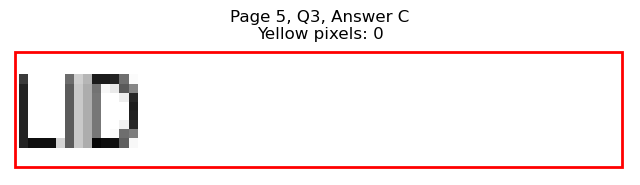

Page 5, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=343.6, y1=278.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 63
Page 5, Q3, D: Yellow percentage: 0.0%


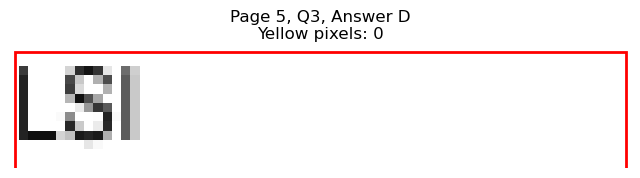


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=105.4, y1=316.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 167
Page 5, Q4, A: Yellow percentage: 0.0%


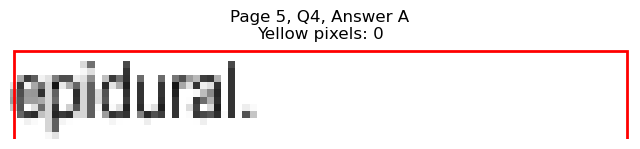

Page 5, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=107.9, y1=329.3
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 205
Page 5, Q4, B: Yellow percentage: 0.0%


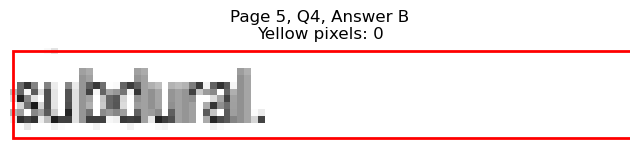

Page 5, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=382.3, y1=316.7
Page 5, Q4, C: Yellow pixels: 1194
Page 5, Q4, C: Total non-white pixels: 1378
Page 5, Q4, C: Yellow percentage: 86.6%


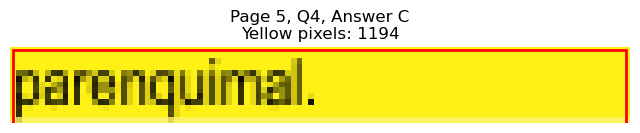

Page 5, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=374.2, y1=329.3
Page 5, Q4, D: Yellow pixels: 98
Page 5, Q4, D: Total non-white pixels: 321
Page 5, Q4, D: Yellow percentage: 30.5%


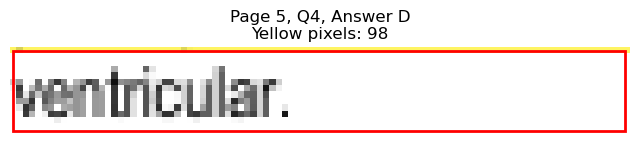


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=112.9, y1=367.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 216
Page 5, Q5, A: Yellow percentage: 0.0%


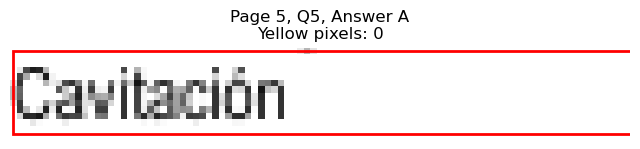

Page 5, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=177.6, y1=379.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 569
Page 5, Q5, B: Yellow percentage: 0.0%


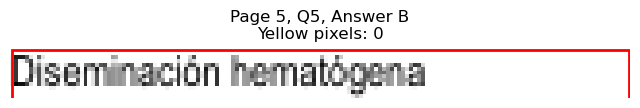

Page 5, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=394.3, y1=367.2
Page 5, Q5, C: Yellow pixels: 118
Page 5, Q5, C: Total non-white pixels: 461
Page 5, Q5, C: Yellow percentage: 25.6%


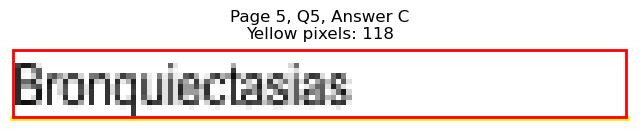

Page 5, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=408.4, y1=379.8
Page 5, Q5, D: Yellow pixels: 1406
Page 5, Q5, D: Total non-white pixels: 1716
Page 5, Q5, D: Yellow percentage: 81.9%


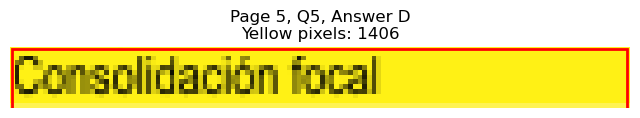


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=172.1, y1=417.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 523
Page 5, Q6, A: Yellow percentage: 0.0%


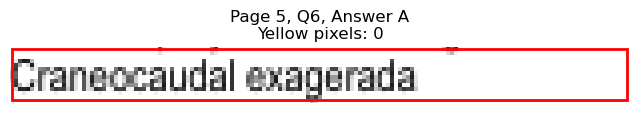

Page 5, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=123.0, y1=430.3
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 259
Page 5, Q6, B: Yellow percentage: 0.0%


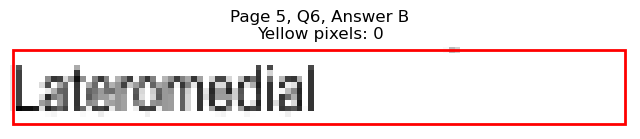

Page 5, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=374.2, y1=417.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 254
Page 5, Q6, C: Yellow percentage: 0.0%


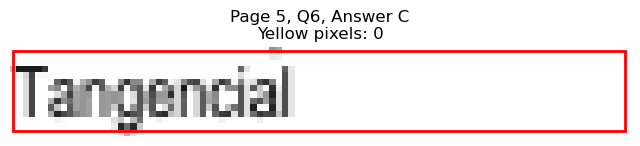

Page 5, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=364.6, y1=430.3
Page 5, Q6, D: Yellow pixels: 899
Page 5, Q6, D: Total non-white pixels: 1232
Page 5, Q6, D: Yellow percentage: 73.0%


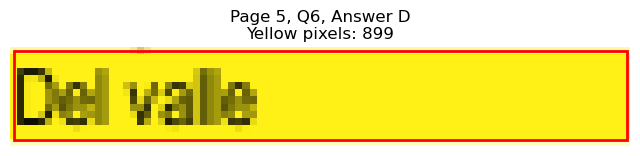


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=159.1, y1=468.1
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 444
Page 5, Q7, A: Yellow percentage: 0.0%


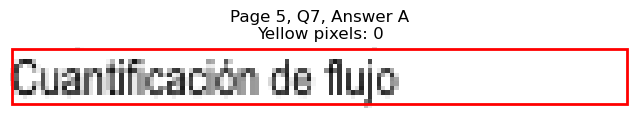

Page 5, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=124.5, y1=480.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 285
Page 5, Q7, B: Yellow percentage: 0.0%


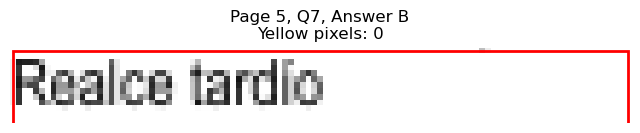

Page 5, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=410.3, y1=468.1
Page 5, Q7, C: Yellow pixels: 1433
Page 5, Q7, C: Total non-white pixels: 1876
Page 5, Q7, C: Yellow percentage: 76.4%


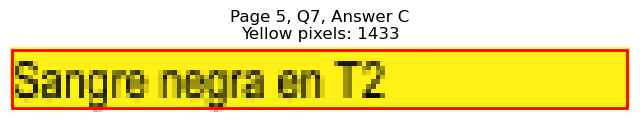

Page 5, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=410.3, y1=480.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 515
Page 5, Q7, D: Yellow percentage: 0.0%


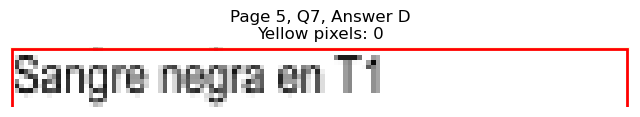


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=170.7, y1=531.2
Page 5, Q8, A: Yellow pixels: 1582
Page 5, Q8, A: Total non-white pixels: 2142
Page 5, Q8, A: Yellow percentage: 73.9%


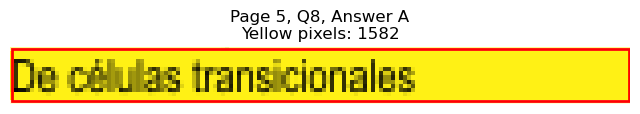

Page 5, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=112.9, y1=543.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 314
Page 5, Q8, B: Yellow percentage: 0.0%


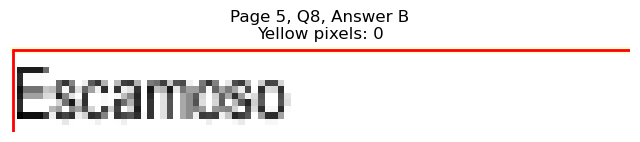

Page 5, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=374.2, y1=531.2
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 233
Page 5, Q8, C: Yellow percentage: 0.0%


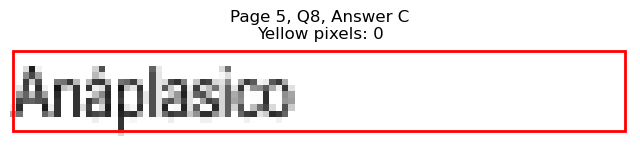

Page 5, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=404.2, y1=543.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 399
Page 5, Q8, D: Yellow percentage: 0.0%


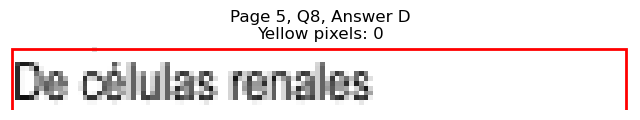


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=189.6, y1=594.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 634
Page 5, Q9, A: Yellow percentage: 0.0%


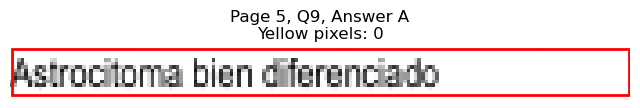

Page 5, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=164.1, y1=607.0
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 487
Page 5, Q9, B: Yellow percentage: 0.0%


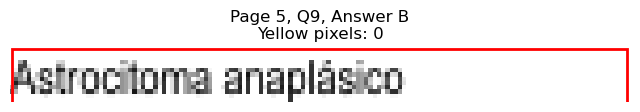

Page 5, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=442.9, y1=594.4
Page 5, Q9, C: Yellow pixels: 166
Page 5, Q9, C: Total non-white pixels: 763
Page 5, Q9, C: Yellow percentage: 21.8%


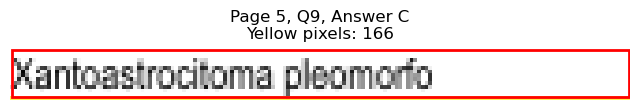

Page 5, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=443.3, y1=607.0
Page 5, Q9, D: Yellow pixels: 1722
Page 5, Q9, D: Total non-white pixels: 2171
Page 5, Q9, D: Yellow percentage: 79.3%


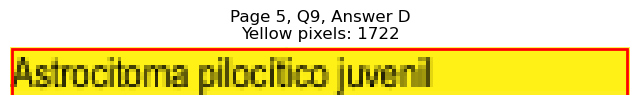


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=121.5, y1=644.9
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 258
Page 5, Q10, A: Yellow percentage: 0.0%


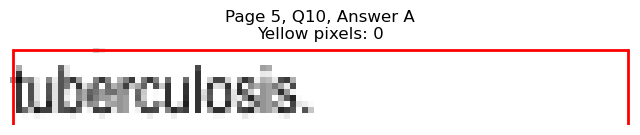

Page 5, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=132.5, y1=657.5
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 337
Page 5, Q10, B: Yellow percentage: 0.0%


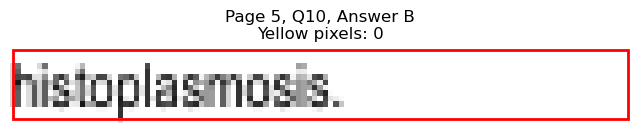

Page 5, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=428.8, y1=644.9
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 655
Page 5, Q10, C: Yellow percentage: 0.0%


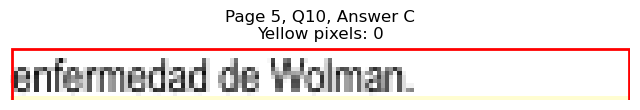

Page 5, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=378.2, y1=657.5
Page 5, Q10, D: Yellow pixels: 1128
Page 5, Q10, D: Total non-white pixels: 1428
Page 5, Q10, D: Yellow percentage: 79.0%


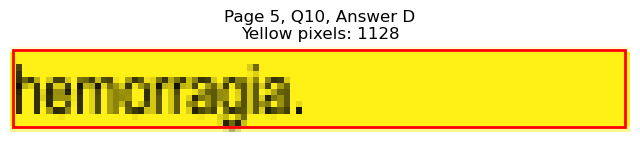


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=167.1, y1=708.0
Page 5, Q11, A: Yellow pixels: 150
Page 5, Q11, A: Total non-white pixels: 790
Page 5, Q11, A: Yellow percentage: 19.0%


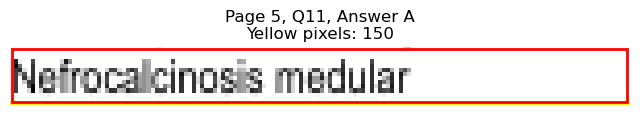

Page 5, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=163.1, y1=720.6
Page 5, Q11, B: Yellow pixels: 1519
Page 5, Q11, B: Total non-white pixels: 2044
Page 5, Q11, B: Yellow percentage: 74.3%


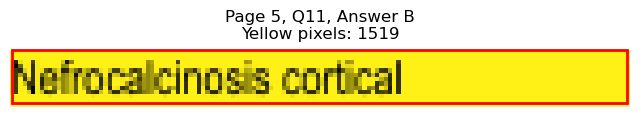

Page 5, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=387.2, y1=708.0
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 327
Page 5, Q11, C: Yellow percentage: 0.0%


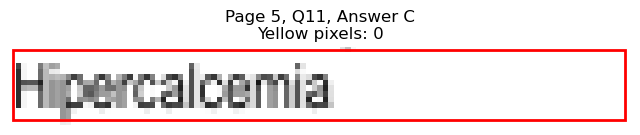

Page 5, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=414.8, y1=720.6
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 472
Page 5, Q11, D: Yellow percentage: 0.0%


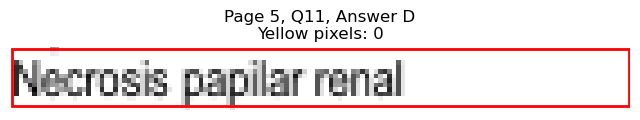


Page 5, Q11 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=117.5, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 262
Page 6, Q1, A: Yellow percentage: 0.0%


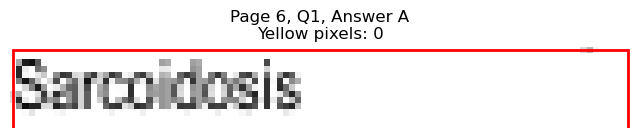

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=166.6, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 511
Page 6, Q1, B: Yellow percentage: 0.0%


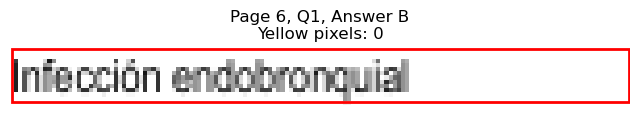

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=407.2, y1=114.7
Page 6, Q1, C: Yellow pixels: 1402
Page 6, Q1, C: Total non-white pixels: 1703
Page 6, Q1, C: Yellow percentage: 82.3%


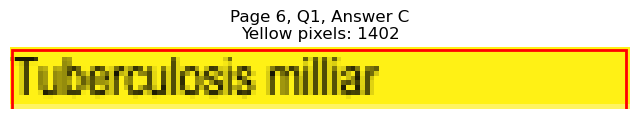

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=434.3, y1=127.3
Page 6, Q1, D: Yellow pixels: 158
Page 6, Q1, D: Total non-white pixels: 707
Page 6, Q1, D: Yellow percentage: 22.3%


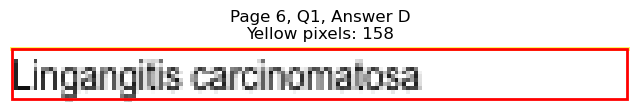


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=159.6, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 471
Page 6, Q2, A: Yellow percentage: 0.0%


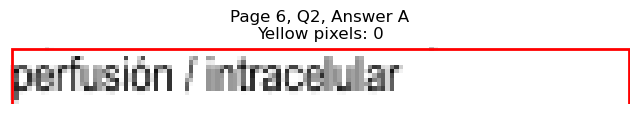

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=158.5, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 436
Page 6, Q2, B: Yellow percentage: 0.0%


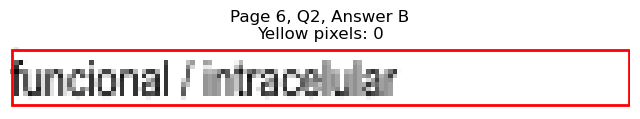

Page 6, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=442.9, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 745
Page 6, Q2, C: Yellow percentage: 0.0%


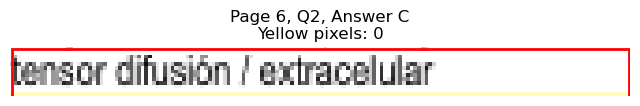

Page 6, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=415.3, y1=190.4
Page 6, Q2, D: Yellow pixels: 1335
Page 6, Q2, D: Total non-white pixels: 1946
Page 6, Q2, D: Yellow percentage: 68.6%


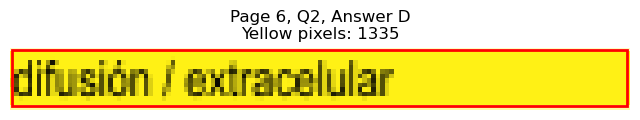


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=141.0, y1=253.5
Page 6, Q3, A: Yellow pixels: 124
Page 6, Q3, A: Total non-white pixels: 489
Page 6, Q3, A: Yellow percentage: 25.4%


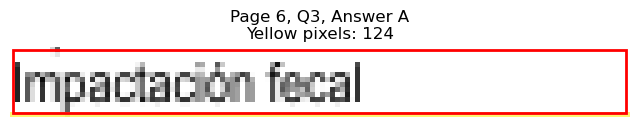

Page 6, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=106.9, y1=266.1
Page 6, Q3, B: Yellow pixels: 1025
Page 6, Q3, B: Total non-white pixels: 1246
Page 6, Q3, B: Yellow percentage: 82.3%


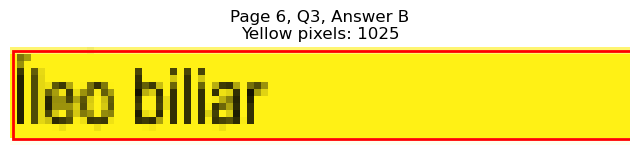

Page 6, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=380.2, y1=253.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 260
Page 6, Q3, C: Yellow percentage: 0.0%


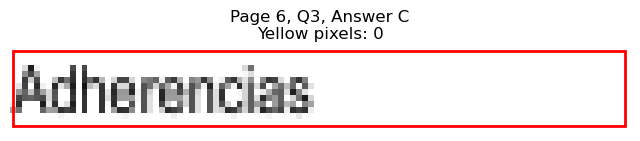

Page 6, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=413.8, y1=266.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 458
Page 6, Q3, D: Yellow percentage: 0.0%


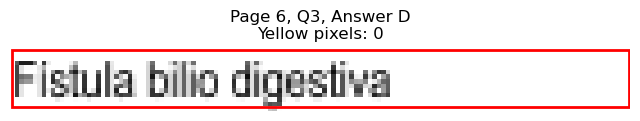


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=200.8, y1=304.1
Page 6, Q4, A: Yellow pixels: 1883
Page 6, Q4, A: Total non-white pixels: 2562
Page 6, Q4, A: Yellow percentage: 73.5%


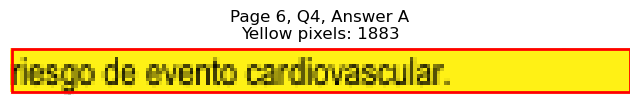

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=204.6, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 842
Page 6, Q4, B: Yellow percentage: 0.0%


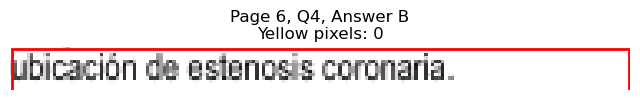

Page 6, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=449.0, y1=304.1
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 589
Page 6, Q4, C: Yellow percentage: 0.0%


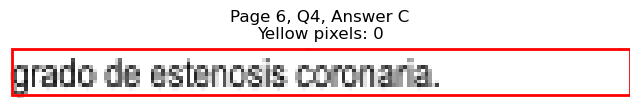

Page 6, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=379.1, y1=316.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 276
Page 6, Q4, D: Yellow percentage: 0.0%


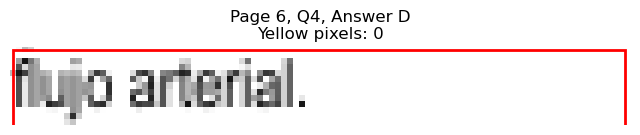


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=110.9, y1=379.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 221
Page 6, Q5, A: Yellow percentage: 0.0%


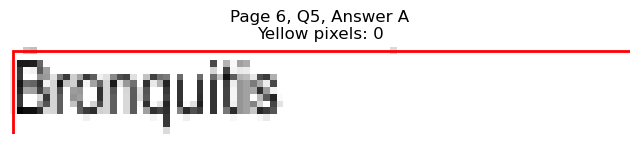

Page 6, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=143.5, y1=392.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 368
Page 6, Q5, B: Yellow percentage: 0.0%


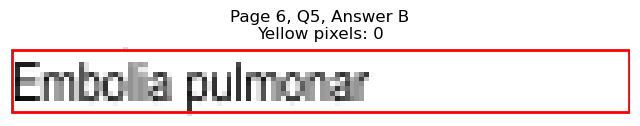

Page 6, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=401.8, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 506
Page 6, Q5, C: Yellow percentage: 0.0%


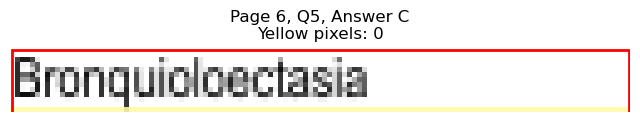

Page 6, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=394.3, y1=392.4
Page 6, Q5, D: Yellow pixels: 1165
Page 6, Q5, D: Total non-white pixels: 1652
Page 6, Q5, D: Yellow percentage: 70.5%


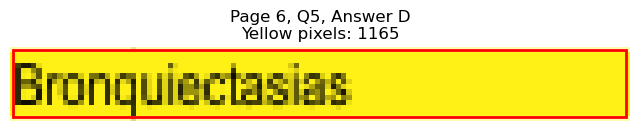


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=172.1, y1=442.9
Page 6, Q6, A: Yellow pixels: 1615
Page 6, Q6, A: Total non-white pixels: 2015
Page 6, Q6, A: Yellow percentage: 80.1%


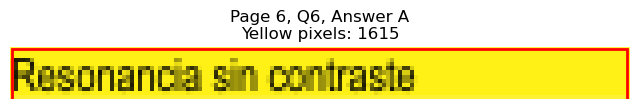

Page 6, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=175.6, y1=455.5
Page 6, Q6, B: Yellow pixels: 158
Page 6, Q6, B: Total non-white pixels: 687
Page 6, Q6, B: Yellow percentage: 23.0%


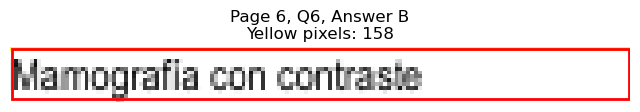

Page 6, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=434.3, y1=442.9
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 519
Page 6, Q6, C: Yellow percentage: 0.0%


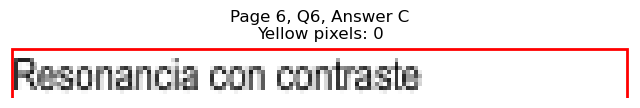

Page 6, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=431.8, y1=455.5
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 538
Page 6, Q6, D: Yellow percentage: 0.0%


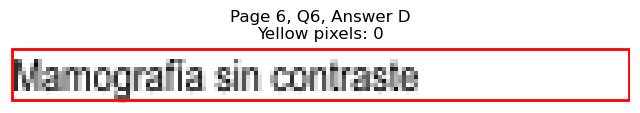


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=143.5, y1=518.6
Page 6, Q7, A: Yellow pixels: 1328
Page 6, Q7, A: Total non-white pixels: 1764
Page 6, Q7, A: Yellow percentage: 75.3%


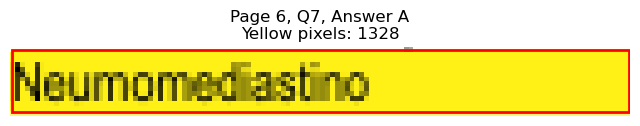

Page 6, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=120.5, y1=531.2
Page 6, Q7, B: Yellow pixels: 103
Page 6, Q7, B: Total non-white pixels: 414
Page 6, Q7, B: Yellow percentage: 24.9%


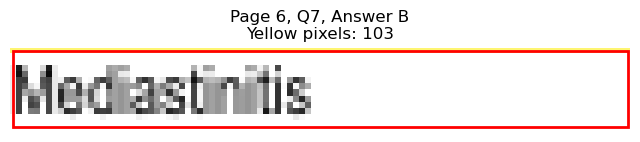

Page 6, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=379.1, y1=518.6
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 272
Page 6, Q7, C: Yellow percentage: 0.0%


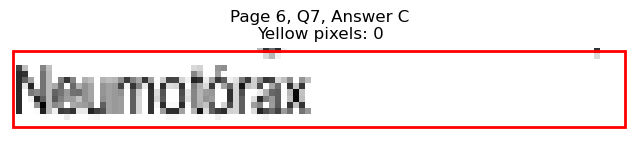

Page 6, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=398.2, y1=531.2
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 367
Page 6, Q7, D: Yellow percentage: 0.0%


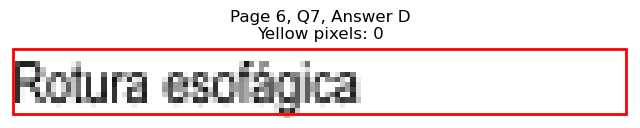


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=132.5, y1=594.4
Page 6, Q8, A: Yellow pixels: 1132
Page 6, Q8, A: Total non-white pixels: 1610
Page 6, Q8, A: Yellow percentage: 70.3%


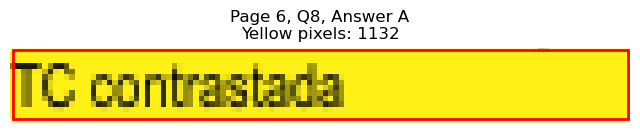

Page 6, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=104.4, y1=607.0
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 259
Page 6, Q8, B: Yellow percentage: 0.0%


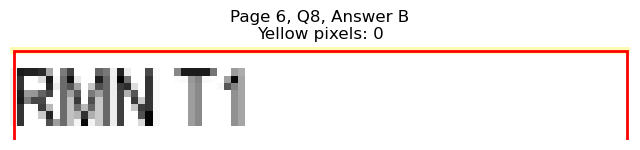

Page 6, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=363.7, y1=594.4
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 168
Page 6, Q8, C: Yellow percentage: 0.0%


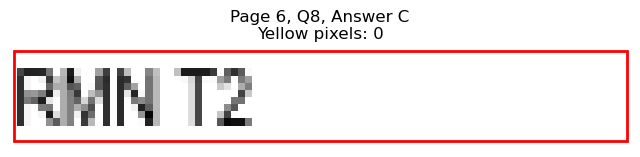

Page 6, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=362.1, y1=607.0
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 156
Page 6, Q8, D: Yellow percentage: 0.0%


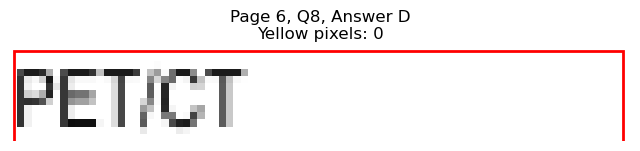


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=152.1, y1=657.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 416
Page 6, Q9, A: Yellow percentage: 0.0%


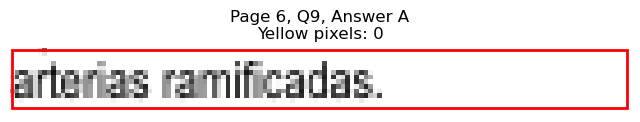

Page 6, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=153.0, y1=670.1
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 428
Page 6, Q9, B: Yellow percentage: 0.0%


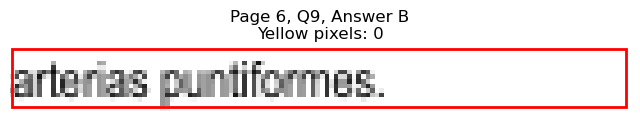

Page 6, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=427.4, y1=657.5
Page 6, Q9, C: Yellow pixels: 1583
Page 6, Q9, C: Total non-white pixels: 2114
Page 6, Q9, C: Yellow percentage: 74.9%


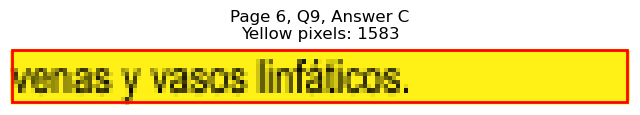

Page 6, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=424.4, y1=670.1
Page 6, Q9, D: Yellow pixels: 147
Page 6, Q9, D: Total non-white pixels: 644
Page 6, Q9, D: Yellow percentage: 22.8%


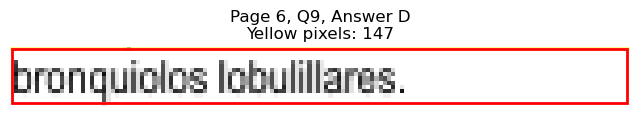


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=138.0, y1=745.8
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 350
Page 6, Q10, A: Yellow percentage: 0.0%


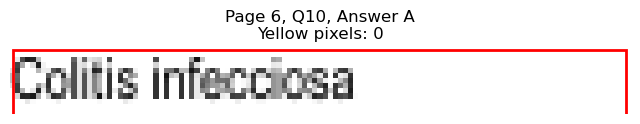

Page 6, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=131.1, y1=758.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 299
Page 6, Q10, B: Yellow percentage: 0.0%


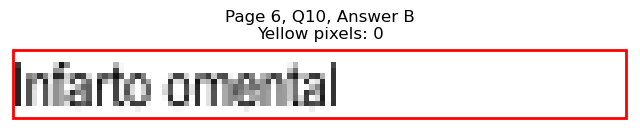

Page 6, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=353.1, y1=745.8
Page 6, Q10, C: Yellow pixels: 895
Page 6, Q10, C: Total non-white pixels: 1001
Page 6, Q10, C: Yellow percentage: 89.4%


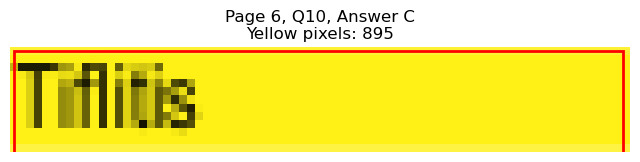

Page 6, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=394.3, y1=758.4
Page 6, Q10, D: Yellow pixels: 118
Page 6, Q10, D: Total non-white pixels: 454
Page 6, Q10, D: Yellow percentage: 26.0%


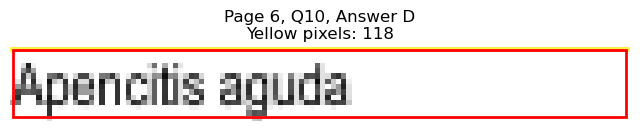


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=114.5, y1=127.3
Page 7, Q1, A: Yellow pixels: 97
Page 7, Q1, A: Total non-white pixels: 316
Page 7, Q1, A: Yellow percentage: 30.7%


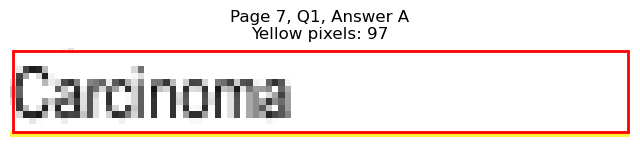

Page 7, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=129.5, y1=139.9
Page 7, Q1, B: Yellow pixels: 1205
Page 7, Q1, B: Total non-white pixels: 1456
Page 7, Q1, B: Yellow percentage: 82.8%


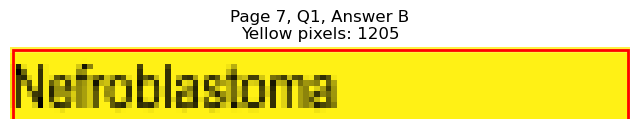

Page 7, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=381.7, y1=127.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 245
Page 7, Q1, C: Yellow percentage: 0.0%


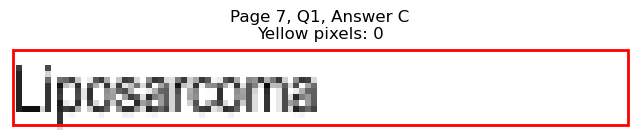

Page 7, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=391.3, y1=139.9
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 343
Page 7, Q1, D: Yellow percentage: 0.0%


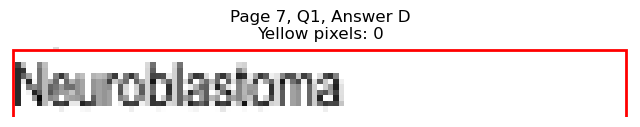


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=100.9, y1=215.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 162
Page 7, Q2, A: Yellow percentage: 0.0%


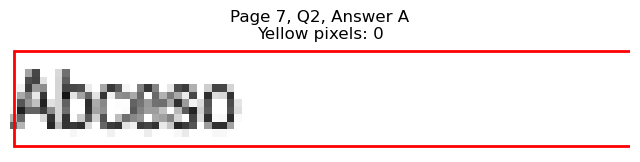

Page 7, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=102.9, y1=228.3
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 165
Page 7, Q2, B: Yellow percentage: 0.0%


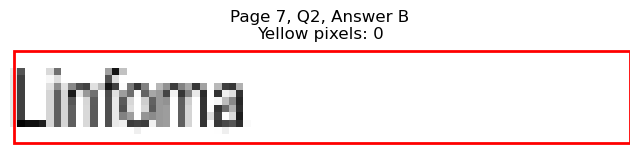

Page 7, Q2 - C: Detected box: x0=327.5, y0=278.8, x1=355.7, y1=291.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 305
Page 7, Q2, C: Yellow percentage: 0.0%


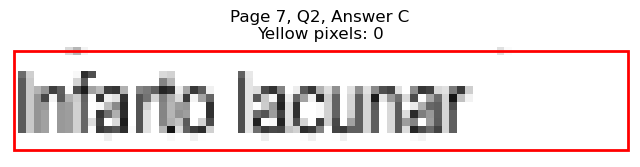

Page 7, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=376.7, y1=228.3
Page 7, Q2, D: Yellow pixels: 100
Page 7, Q2, D: Total non-white pixels: 357
Page 7, Q2, D: Yellow percentage: 28.0%


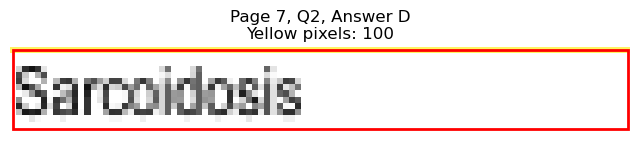


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=161.1, y1=291.5
Page 7, Q3, A: Yellow pixels: 1490
Page 7, Q3, A: Total non-white pixels: 2016
Page 7, Q3, A: Yellow percentage: 73.9%


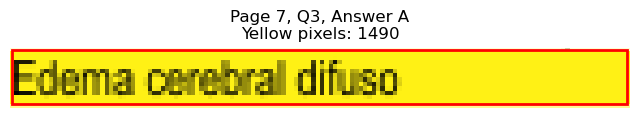

Page 7, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=153.0, y1=304.1
Page 7, Q3, B: Yellow pixels: 136
Page 7, Q3, B: Total non-white pixels: 551
Page 7, Q3, B: Yellow percentage: 24.7%


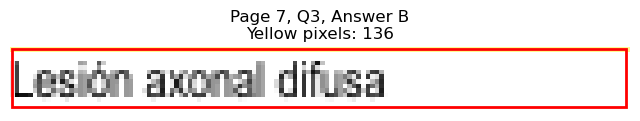

Page 7, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=387.8, y1=291.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 305
Page 7, Q3, C: Yellow percentage: 0.0%


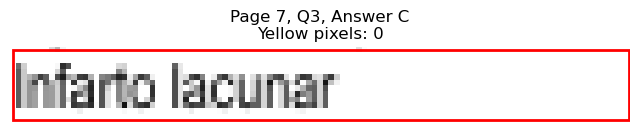

Page 7, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=403.3, y1=304.1
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 372
Page 7, Q3, D: Yellow percentage: 0.0%


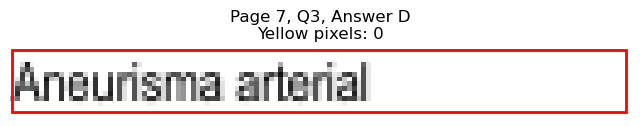


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=116.9, y1=354.6
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 263
Page 7, Q4, A: Yellow percentage: 0.0%


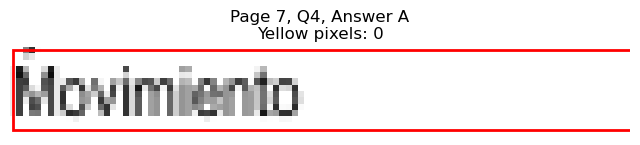

Page 7, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=177.1, y1=367.2
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 538
Page 7, Q4, B: Yellow percentage: 0.0%


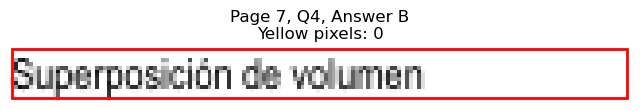

Page 7, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=389.7, y1=354.6
Page 7, Q4, C: Yellow pixels: 113
Page 7, Q4, C: Total non-white pixels: 436
Page 7, Q4, C: Yellow percentage: 25.9%


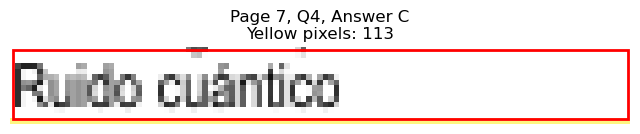

Page 7, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=392.8, y1=367.2
Page 7, Q4, D: Yellow pixels: 1264
Page 7, Q4, D: Total non-white pixels: 1624
Page 7, Q4, D: Yellow percentage: 77.8%


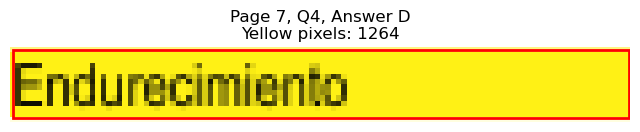


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=112.0, y1=405.0
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 221
Page 7, Q5, A: Yellow percentage: 0.0%


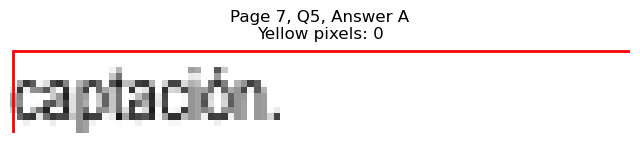

Page 7, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=112.0, y1=417.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 216
Page 7, Q5, B: Yellow percentage: 0.0%


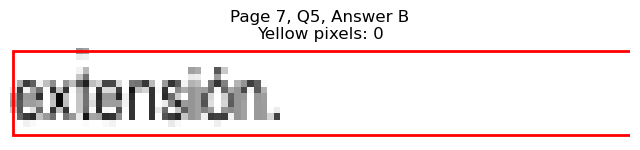

Page 7, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=368.2, y1=405.0
Page 7, Q5, C: Yellow pixels: 1038
Page 7, Q5, C: Total non-white pixels: 1196
Page 7, Q5, C: Yellow percentage: 86.8%


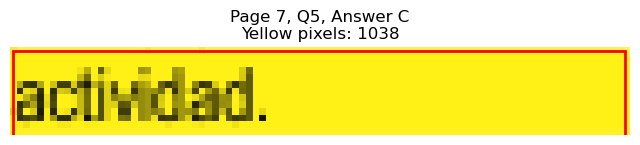

Page 7, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=362.7, y1=417.6
Page 7, Q5, D: Yellow pixels: 86
Page 7, Q5, D: Total non-white pixels: 252
Page 7, Q5, D: Yellow percentage: 34.1%


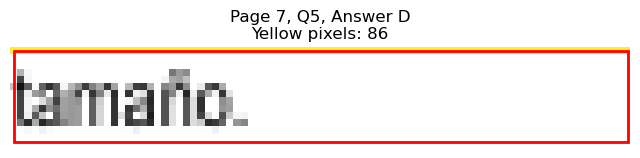


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=146.1, y1=468.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 335
Page 7, Q6, A: Yellow percentage: 0.0%


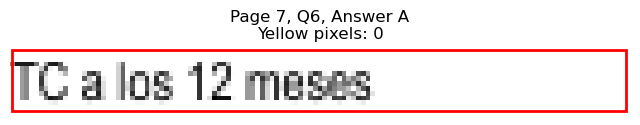

Page 7, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=102.9, y1=480.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 157
Page 7, Q6, B: Yellow percentage: 0.0%


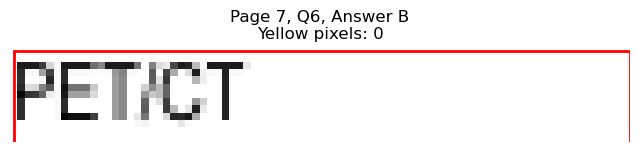

Page 7, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=359.7, y1=468.1
Page 7, Q6, C: Yellow pixels: 83
Page 7, Q6, C: Total non-white pixels: 259
Page 7, Q6, C: Yellow percentage: 32.0%


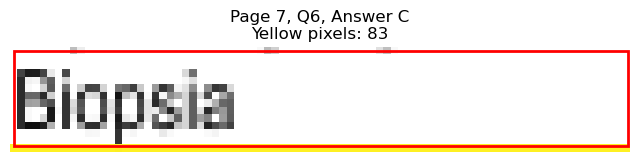

Page 7, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=394.3, y1=480.7
Page 7, Q6, D: Yellow pixels: 1285
Page 7, Q6, D: Total non-white pixels: 1534
Page 7, Q6, D: Yellow percentage: 83.8%


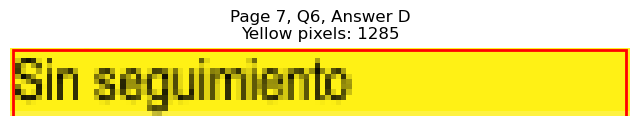


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=102.9, y1=531.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 158
Page 7, Q7, A: Yellow percentage: 0.0%


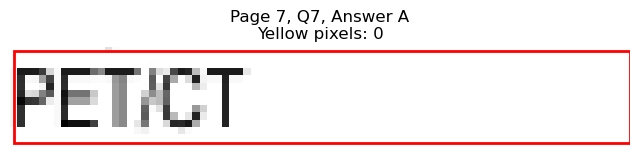

Page 7, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=82.8, y1=543.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 51
Page 7, Q7, B: Yellow percentage: 0.0%


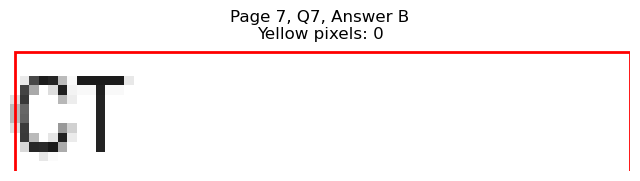

Page 7, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=428.3, y1=531.2
Page 7, Q7, C: Yellow pixels: 1599
Page 7, Q7, C: Total non-white pixels: 2128
Page 7, Q7, C: Yellow percentage: 75.1%


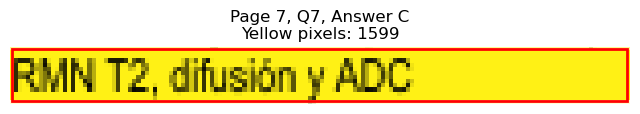

Page 7, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=440.3, y1=543.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 657
Page 7, Q7, D: Yellow percentage: 0.0%


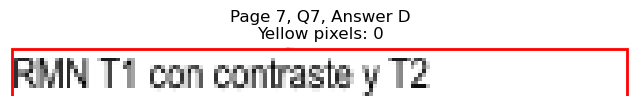


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=106.9, y1=594.4
Page 7, Q8, A: Yellow pixels: 89
Page 7, Q8, A: Total non-white pixels: 257
Page 7, Q8, A: Yellow percentage: 34.6%


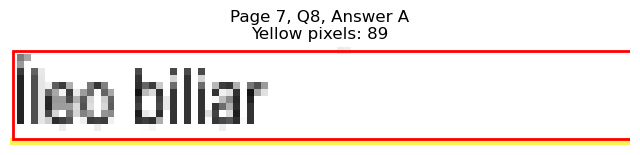

Page 7, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=131.1, y1=607.0
Page 7, Q8, B: Yellow pixels: 1232
Page 7, Q8, B: Total non-white pixels: 1482
Page 7, Q8, B: Yellow percentage: 83.1%


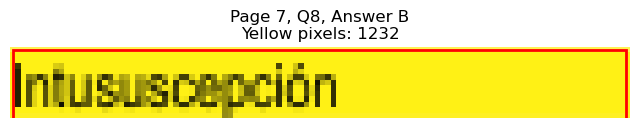

Page 7, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=370.1, y1=594.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 235
Page 7, Q8, C: Yellow percentage: 0.0%


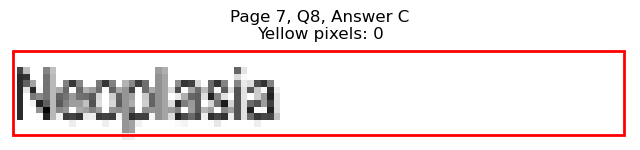

Page 7, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=356.6, y1=607.0
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 148
Page 7, Q8, D: Yellow percentage: 0.0%


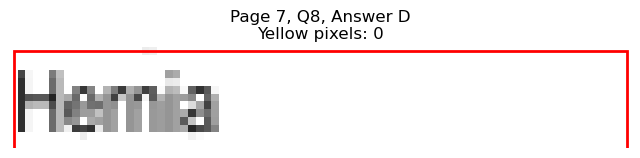


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=138.5, y1=657.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 346
Page 7, Q9, A: Yellow percentage: 0.0%


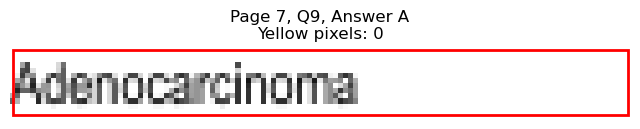

Page 7, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=113.9, y1=670.1
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 268
Page 7, Q9, B: Yellow percentage: 0.0%


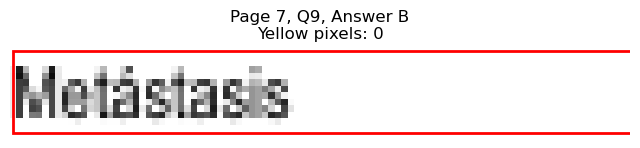

Page 7, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=366.2, y1=657.5
Page 7, Q9, C: Yellow pixels: 90
Page 7, Q9, C: Total non-white pixels: 284
Page 7, Q9, C: Yellow percentage: 31.7%


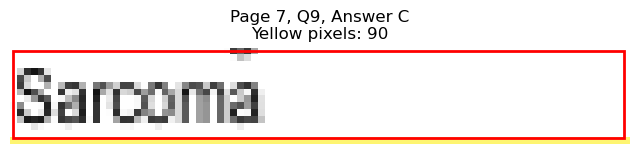

Page 7, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=377.2, y1=670.1
Page 7, Q9, D: Yellow pixels: 1114
Page 7, Q9, D: Total non-white pixels: 1414
Page 7, Q9, D: Yellow percentage: 78.8%


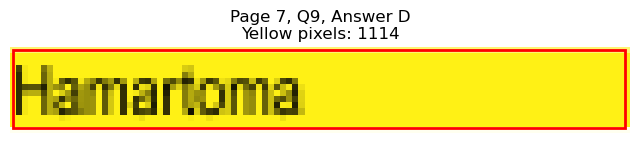


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=708.0, x1=124.0, y1=720.6
Page 7, Q10, A: Yellow pixels: 106
Page 7, Q10, A: Total non-white pixels: 402
Page 7, Q10, A: Yellow percentage: 26.4%


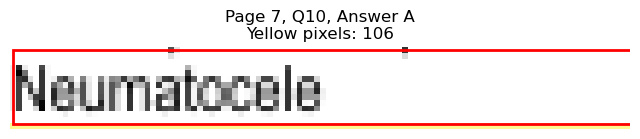

Page 7, Q10 - B: Detected box: x0=68.3, y0=720.6, x1=90.9, y1=733.2
Page 7, Q10, B: Yellow pixels: 849
Page 7, Q10, B: Total non-white pixels: 1022
Page 7, Q10, B: Yellow percentage: 83.1%


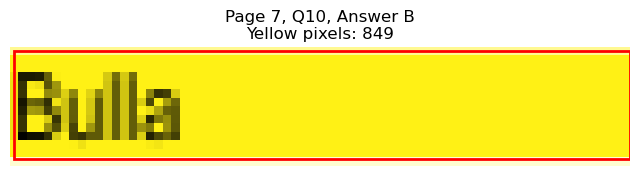

Page 7, Q10 - C: Detected box: x0=327.5, y0=708.0, x1=389.7, y1=720.6
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 326
Page 7, Q10, C: Yellow percentage: 0.0%


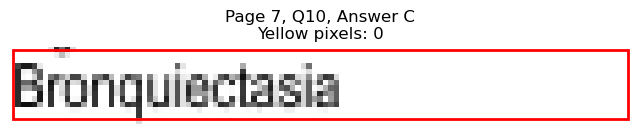

Page 7, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=396.3, y1=733.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 345
Page 7, Q10, D: Yellow percentage: 0.0%


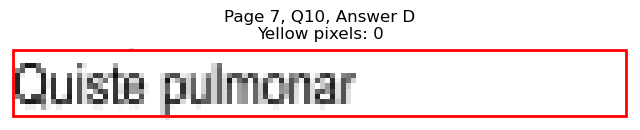


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=117.6, y1=127.3
Page 8, Q1, A: Yellow pixels: 100
Page 8, Q1, A: Total non-white pixels: 382
Page 8, Q1, A: Yellow percentage: 26.2%


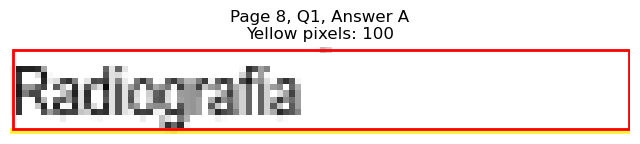

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=109.5, y1=139.9
Page 8, Q1, B: Yellow pixels: 1015
Page 8, Q1, B: Total non-white pixels: 1196
Page 8, Q1, B: Yellow percentage: 84.9%


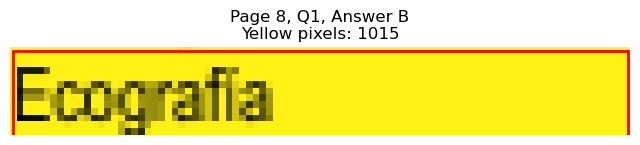

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=376.3, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 240
Page 8, Q1, C: Yellow percentage: 0.0%


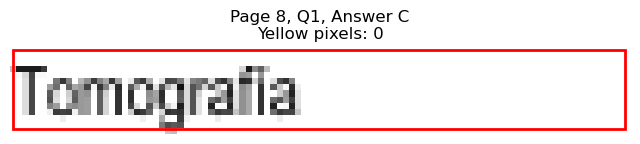

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=377.7, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 261
Page 8, Q1, D: Yellow percentage: 0.0%


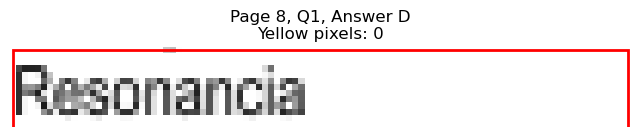


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=101.4, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 245
Page 8, Q2, A: Yellow percentage: 0.0%


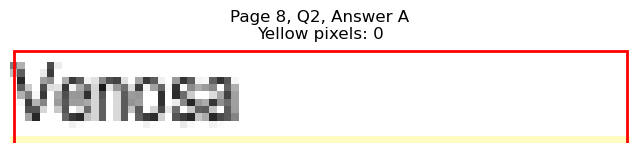

Page 8, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=97.0, y1=190.4
Page 8, Q2, B: Yellow pixels: 843
Page 8, Q2, B: Total non-white pixels: 1106
Page 8, Q2, B: Yellow percentage: 76.2%


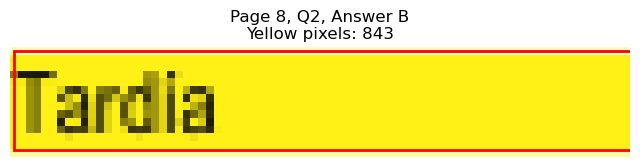

Page 8, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=358.6, y1=177.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 161
Page 8, Q2, C: Yellow percentage: 0.0%


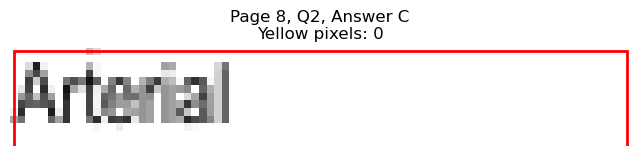

Page 8, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=382.7, y1=190.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 266
Page 8, Q2, D: Yellow percentage: 0.0%


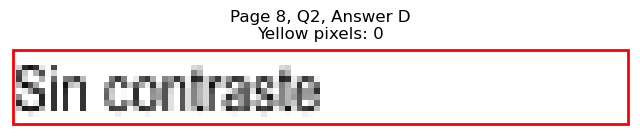


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=56.6, y0=240.9, x1=65.2, y1=253.5
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 51
Page 8, Q3, A: Yellow percentage: 0.0%


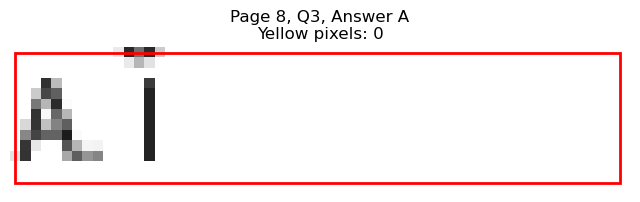

Page 8, Q3 - B: Detected box: x0=56.6, y0=253.5, x1=65.2, y1=266.1
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 66
Page 8, Q3, B: Yellow percentage: 0.0%


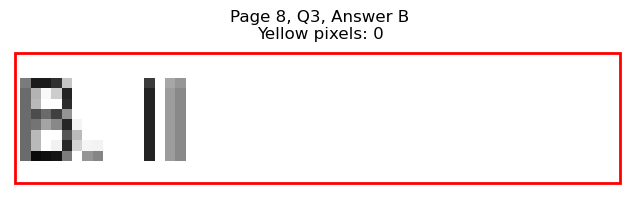

Page 8, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=338.6, y1=253.5
Page 8, Q3, C: Yellow pixels: 62
Page 8, Q3, C: Total non-white pixels: 104
Page 8, Q3, C: Yellow percentage: 59.6%


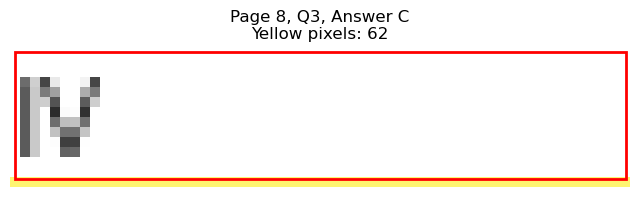

Page 8, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=337.6, y1=266.1
Page 8, Q3, D: Yellow pixels: 753
Page 8, Q3, D: Total non-white pixels: 854
Page 8, Q3, D: Yellow percentage: 88.2%


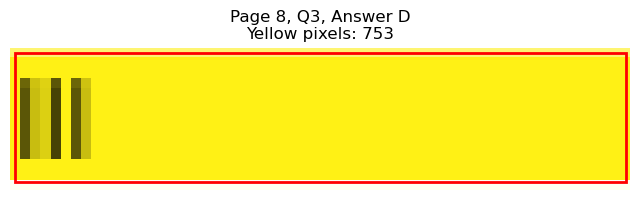


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=188.2, y1=304.1
Page 8, Q4, A: Yellow pixels: 1750
Page 8, Q4, A: Total non-white pixels: 2394
Page 8, Q4, A: Yellow percentage: 73.1%


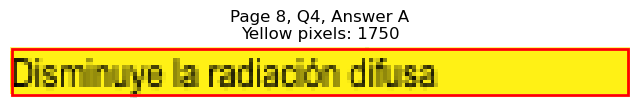

Page 8, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=233.3, y1=316.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 1022
Page 8, Q4, B: Yellow percentage: 0.0%


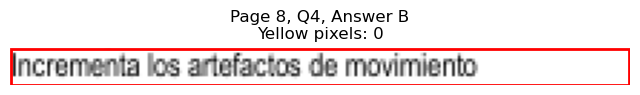

Page 8, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=489.6, y1=304.1
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 812
Page 8, Q4, C: Yellow percentage: 0.0%


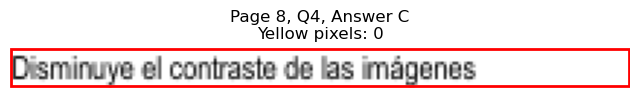

Page 8, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=459.9, y1=316.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 633
Page 8, Q4, D: Yellow percentage: 0.0%


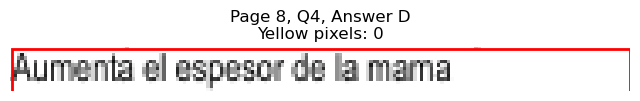


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=160.1, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 449
Page 8, Q5, A: Yellow percentage: 0.0%


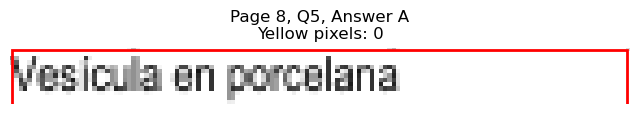

Page 8, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=143.5, y1=392.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 415
Page 8, Q5, B: Yellow percentage: 0.0%


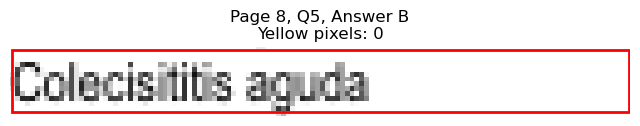

Page 8, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=435.9, y1=379.8
Page 8, Q5, C: Yellow pixels: 1670
Page 8, Q5, C: Total non-white pixels: 2067
Page 8, Q5, C: Yellow percentage: 80.8%


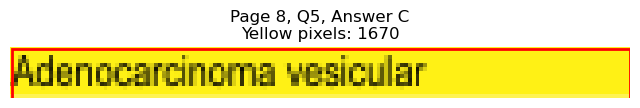

Page 8, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=401.3, y1=392.4
Page 8, Q5, D: Yellow pixels: 125
Page 8, Q5, D: Total non-white pixels: 507
Page 8, Q5, D: Yellow percentage: 24.7%


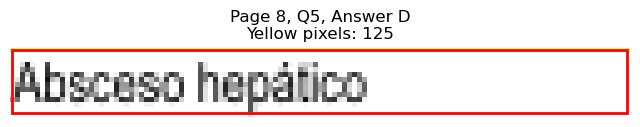


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=167.1, y1=430.3
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 496
Page 8, Q6, A: Yellow percentage: 0.0%


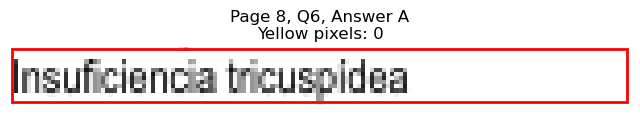

Page 8, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=161.5, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 466
Page 8, Q6, B: Yellow percentage: 0.0%


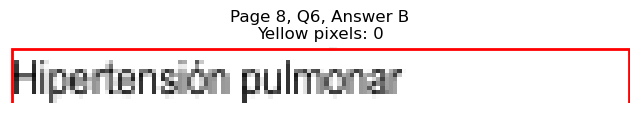

Page 8, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=393.8, y1=430.3
Page 8, Q6, C: Yellow pixels: 1140
Page 8, Q6, C: Total non-white pixels: 1638
Page 8, Q6, C: Yellow percentage: 69.6%


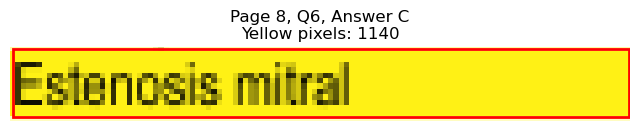

Page 8, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=371.3, y1=442.9
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 319
Page 8, Q6, D: Yellow percentage: 0.0%


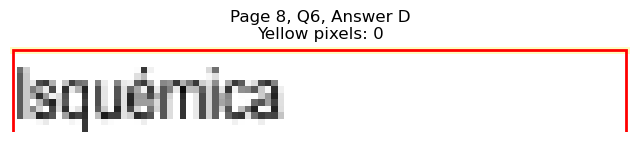


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=164.1, y1=480.7
Page 8, Q7, A: Yellow pixels: 1566
Page 8, Q7, A: Total non-white pixels: 1911
Page 8, Q7, A: Yellow percentage: 81.9%


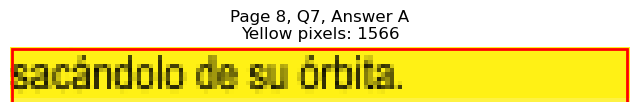

Page 8, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=182.2, y1=493.4
Page 8, Q7, B: Yellow pixels: 165
Page 8, Q7, B: Total non-white pixels: 702
Page 8, Q7, B: Yellow percentage: 23.5%


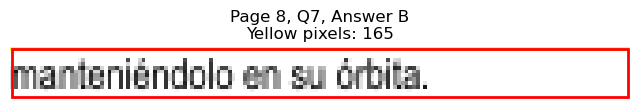

Page 8, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=378.2, y1=480.7
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 213
Page 8, Q7, C: Yellow percentage: 0.0%


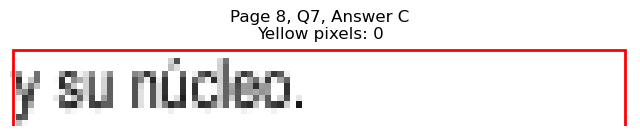

Page 8, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=417.3, y1=493.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 429
Page 8, Q7, D: Yellow percentage: 0.0%


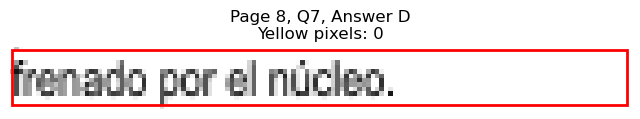


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=162.6, y1=556.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 481
Page 8, Q8, A: Yellow percentage: 0.0%


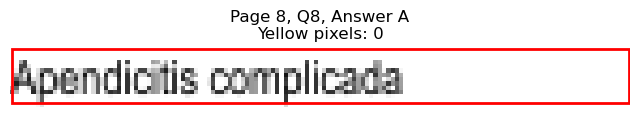

Page 8, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=220.4, y1=569.2
Page 8, Q8, B: Yellow pixels: 2037
Page 8, Q8, B: Total non-white pixels: 2842
Page 8, Q8, B: Yellow percentage: 71.7%


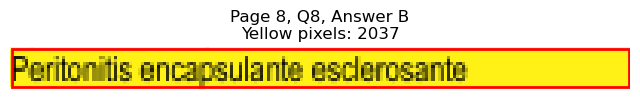

Page 8, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=432.3, y1=556.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 559
Page 8, Q8, C: Yellow percentage: 0.0%


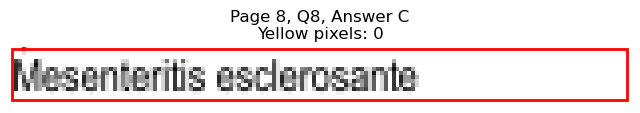

Page 8, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=390.2, y1=569.2
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 323
Page 8, Q8, D: Yellow percentage: 0.0%


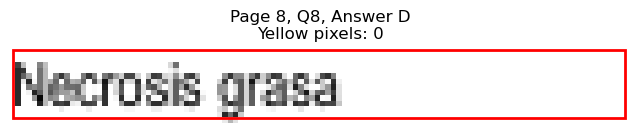


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=168.6, y1=632.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 494
Page 8, Q9, A: Yellow percentage: 0.0%


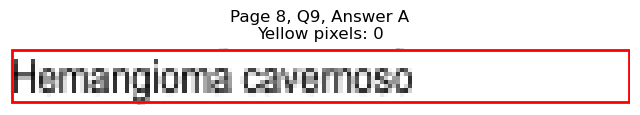

Page 8, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=146.1, y1=644.9
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 396
Page 8, Q9, B: Yellow percentage: 0.0%


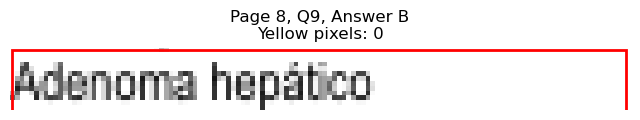

Page 8, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=430.4, y1=632.3
Page 8, Q9, C: Yellow pixels: 154
Page 8, Q9, C: Total non-white pixels: 681
Page 8, Q9, C: Yellow percentage: 22.6%


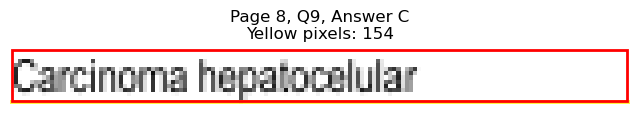

Page 8, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=423.4, y1=644.9
Page 8, Q9, D: Yellow pixels: 1524
Page 8, Q9, D: Total non-white pixels: 1911
Page 8, Q9, D: Yellow percentage: 79.7%


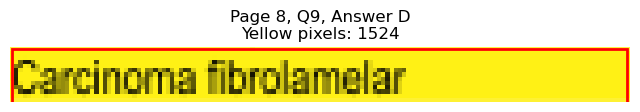


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=682.7, x1=139.0, y1=695.3
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 322
Page 8, Q10, A: Yellow percentage: 0.0%


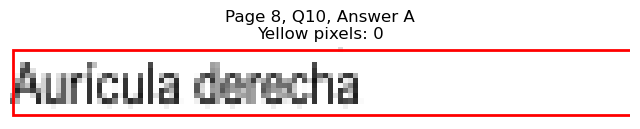

Page 8, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=150.5, y1=708.0
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 422
Page 8, Q10, B: Yellow percentage: 0.0%


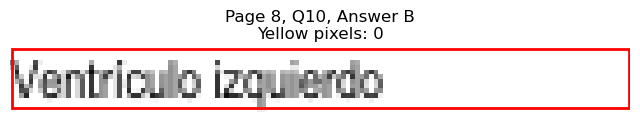

Page 8, Q10 - C: Detected box: x0=327.5, y0=682.7, x1=402.3, y1=695.3
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 370
Page 8, Q10, C: Yellow percentage: 0.0%


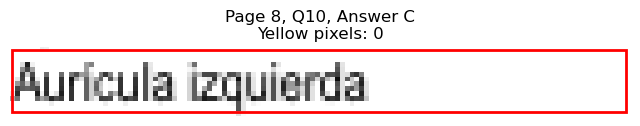

Page 8, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=405.8, y1=708.0
Page 8, Q10, D: Yellow pixels: 1383
Page 8, Q10, D: Total non-white pixels: 1677
Page 8, Q10, D: Yellow percentage: 82.5%


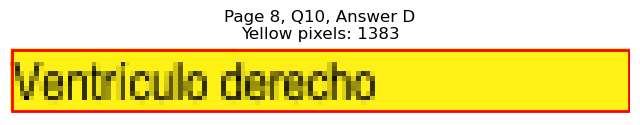


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=80.9, y1=745.8
Page 8, Q11, A: Yellow pixels: 788
Page 8, Q11, A: Total non-white pixels: 819
Page 8, Q11, A: Yellow percentage: 96.2%


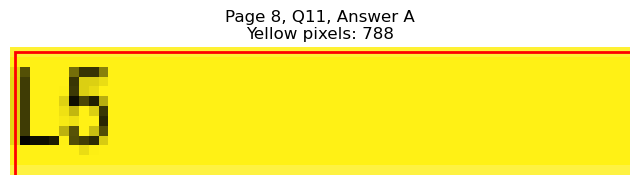

Page 8, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=80.9, y1=758.4
Page 8, Q11, B: Yellow pixels: 63
Page 8, Q11, B: Total non-white pixels: 106
Page 8, Q11, B: Yellow percentage: 59.4%


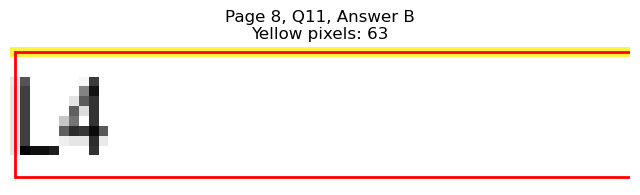

Page 8, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=340.1, y1=745.8
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 42
Page 8, Q11, C: Yellow percentage: 0.0%


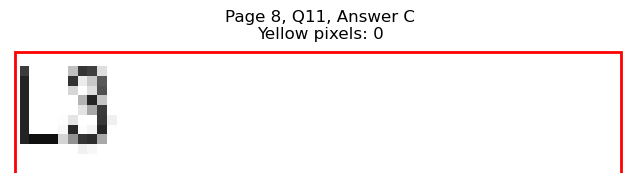

Page 8, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=337.6, y1=758.4
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 37
Page 8, Q11, D: Yellow percentage: 0.0%


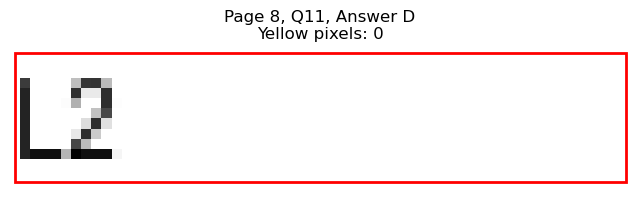


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=119.9, y1=114.7
Page 9, Q1, A: Yellow pixels: 1132
Page 9, Q1, A: Total non-white pixels: 1326
Page 9, Q1, A: Yellow percentage: 85.4%


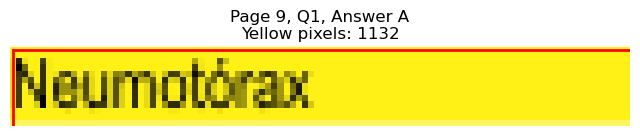

Page 9, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=139.6, y1=127.3
Page 9, Q1, B: Yellow pixels: 122
Page 9, Q1, B: Total non-white pixels: 463
Page 9, Q1, B: Yellow percentage: 26.3%


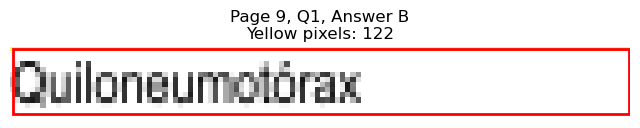

Page 9, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=399.3, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 377
Page 9, Q1, C: Yellow percentage: 0.0%


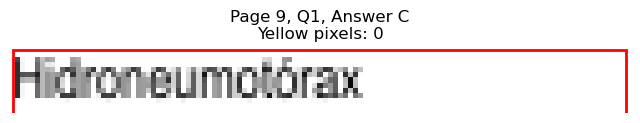

Page 9, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=401.7, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 356
Page 9, Q1, D: Yellow percentage: 0.0%


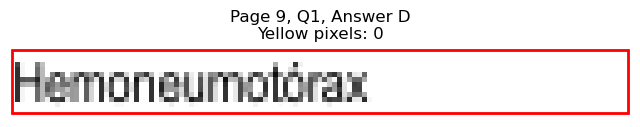


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=130.5, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 429
Page 9, Q2, A: Yellow percentage: 0.0%


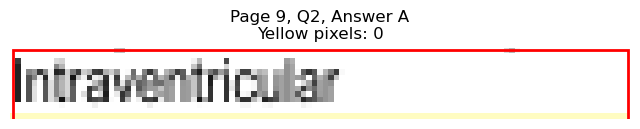

Page 9, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=103.9, y1=190.4
Page 9, Q2, B: Yellow pixels: 898
Page 9, Q2, B: Total non-white pixels: 1204
Page 9, Q2, B: Yellow percentage: 74.6%


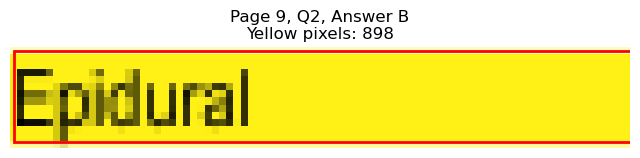

Page 9, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=366.2, y1=177.8
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 186
Page 9, Q2, C: Yellow percentage: 0.0%


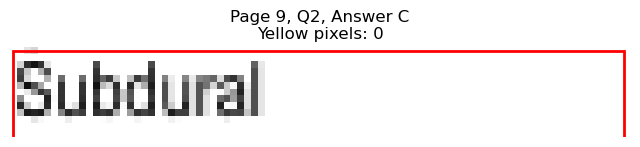

Page 9, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=390.8, y1=190.4
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 314
Page 9, Q2, D: Yellow percentage: 0.0%


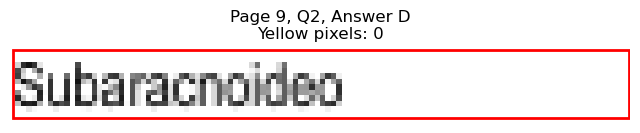


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=119.9, y1=240.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 242
Page 9, Q3, A: Yellow percentage: 0.0%


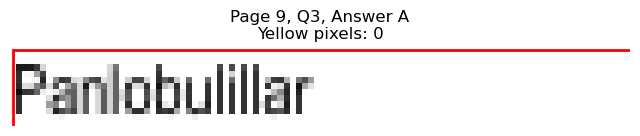

Page 9, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=100.5, y1=253.5
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 174
Page 9, Q3, B: Yellow percentage: 0.0%


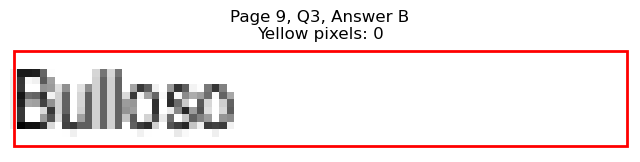

Page 9, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=373.1, y1=240.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 329
Page 9, Q3, C: Yellow percentage: 0.0%


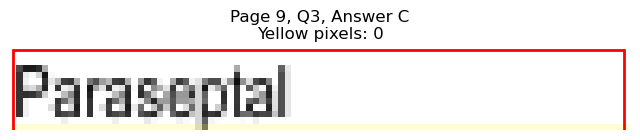

Page 9, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=390.2, y1=253.5
Page 9, Q3, D: Yellow pixels: 1242
Page 9, Q3, D: Total non-white pixels: 1596
Page 9, Q3, D: Yellow percentage: 77.8%


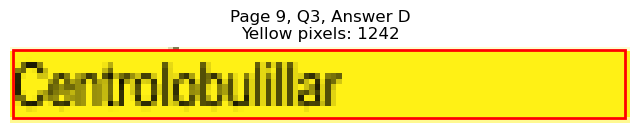


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=132.0, y1=304.1
Page 9, Q4, A: Yellow pixels: 115
Page 9, Q4, A: Total non-white pixels: 440
Page 9, Q4, A: Yellow percentage: 26.1%


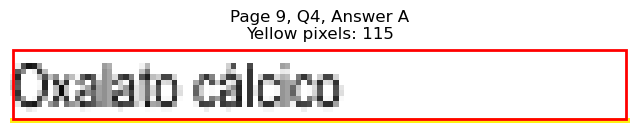

Page 9, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=153.0, y1=316.7
Page 9, Q4, B: Yellow pixels: 1457
Page 9, Q4, B: Total non-white pixels: 1768
Page 9, Q4, B: Yellow percentage: 82.4%


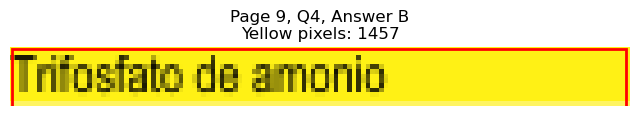

Page 9, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=390.2, y1=304.1
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 313
Page 9, Q4, C: Yellow percentage: 0.0%


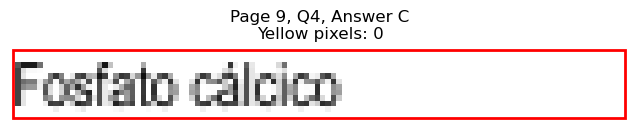

Page 9, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=364.1, y1=316.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 193
Page 9, Q4, D: Yellow percentage: 0.0%


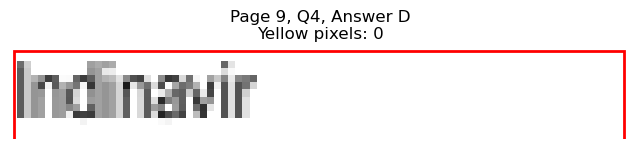


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=118.9, y1=379.8
Page 9, Q5, A: Yellow pixels: 1086
Page 9, Q5, A: Total non-white pixels: 1313
Page 9, Q5, A: Yellow percentage: 82.7%


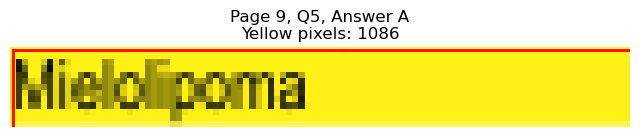

Page 9, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=113.9, y1=392.4
Page 9, Q5, B: Yellow pixels: 96
Page 9, Q5, B: Total non-white pixels: 364
Page 9, Q5, B: Yellow percentage: 26.4%


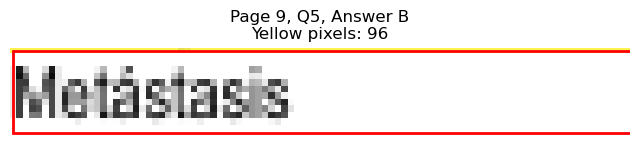

Page 9, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=380.2, y1=379.8
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 267
Page 9, Q5, C: Yellow percentage: 0.0%


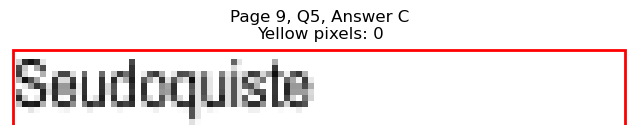

Page 9, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=377.2, y1=392.4
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 257
Page 9, Q5, D: Yellow percentage: 0.0%


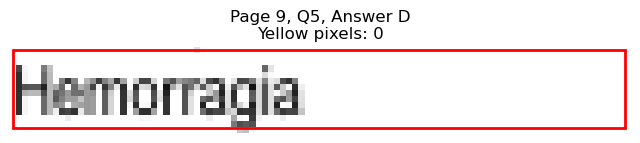


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=192.6, y1=430.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 651
Page 9, Q6, A: Yellow percentage: 0.0%


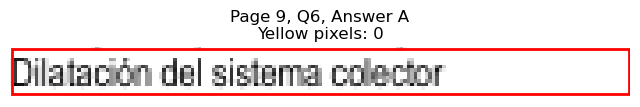

Page 9, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=269.4, y1=442.9
Page 9, Q6, B: Yellow pixels: 62
Page 9, Q6, B: Total non-white pixels: 1079
Page 9, Q6, B: Yellow percentage: 5.7%


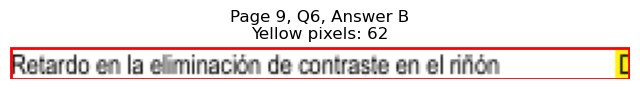

Page 9, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=433.4, y1=430.3
Page 9, Q6, C: Yellow pixels: 157
Page 9, Q6, C: Total non-white pixels: 714
Page 9, Q6, C: Yellow percentage: 22.0%


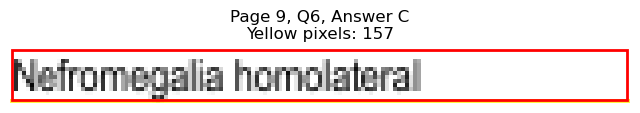

Page 9, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=501.1, y1=442.9
Page 9, Q6, D: Yellow pixels: 2079
Page 9, Q6, D: Total non-white pixels: 2782
Page 9, Q6, D: Yellow percentage: 74.7%


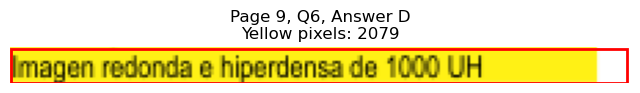


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=65.2, y1=493.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 68
Page 9, Q7, A: Yellow percentage: 0.0%


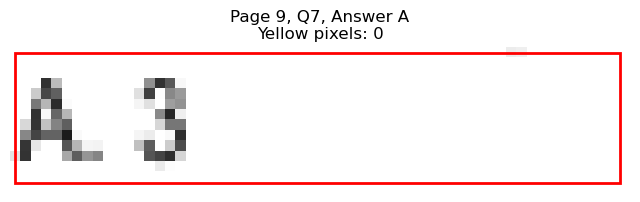

Page 9, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=65.2, y1=506.0
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 74
Page 9, Q7, B: Yellow percentage: 0.0%


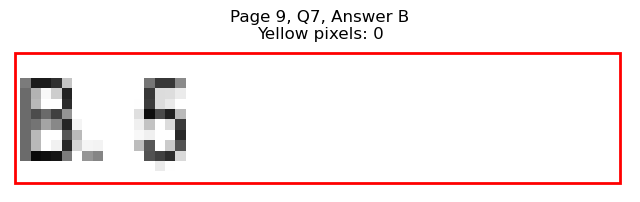

Page 9, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=324.4, y1=493.4
Page 9, Q7, C: Yellow pixels: 675
Page 9, Q7, C: Total non-white pixels: 840
Page 9, Q7, C: Yellow percentage: 80.4%


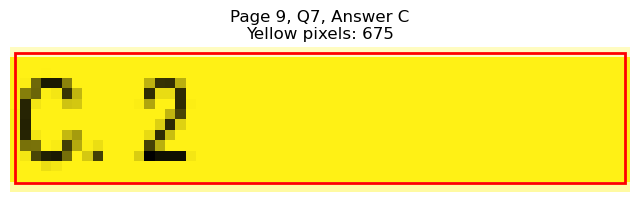

Page 9, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=324.4, y1=506.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 133
Page 9, Q7, D: Yellow percentage: 0.0%


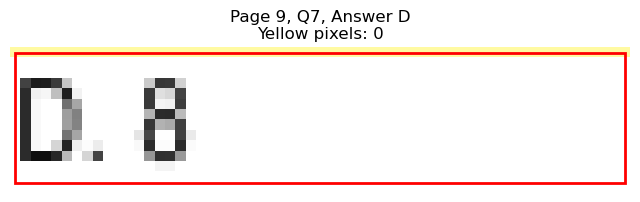


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=173.1, y1=556.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 558
Page 9, Q8, A: Yellow percentage: 0.0%


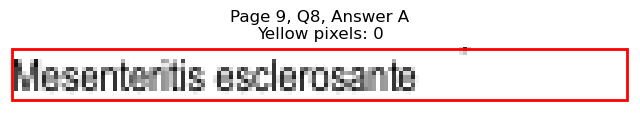

Page 9, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=163.1, y1=569.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 496
Page 9, Q8, B: Yellow percentage: 0.0%


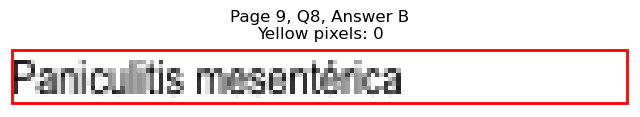

Page 9, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=484.5, y1=556.4
Page 9, Q8, C: Yellow pixels: 2055
Page 9, Q8, C: Total non-white pixels: 2912
Page 9, Q8, C: Yellow percentage: 70.6%


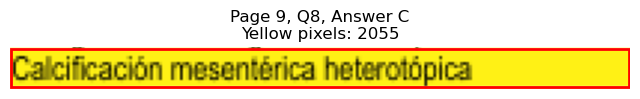

Page 9, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=410.8, y1=569.2
Page 9, Q8, D: Yellow pixels: 134
Page 9, Q8, D: Total non-white pixels: 593
Page 9, Q8, D: Yellow percentage: 22.6%


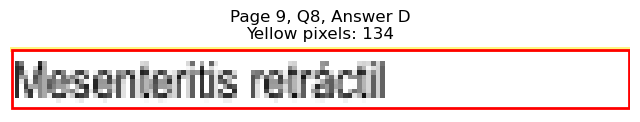


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=90.4, y1=619.6
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 97
Page 9, Q9, A: Yellow percentage: 0.0%


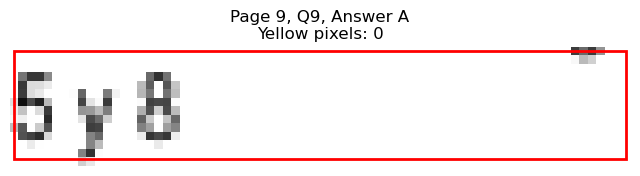

Page 9, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=90.4, y1=632.3
Page 9, Q9, B: Yellow pixels: 814
Page 9, Q9, B: Total non-white pixels: 1022
Page 9, Q9, B: Yellow percentage: 79.6%


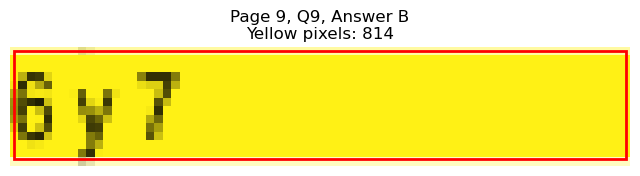

Page 9, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=359.7, y1=619.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 116
Page 9, Q9, C: Yellow percentage: 0.0%


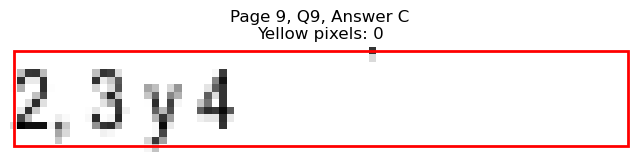

Page 9, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=379.7, y1=632.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 199
Page 9, Q9, D: Yellow percentage: 0.0%


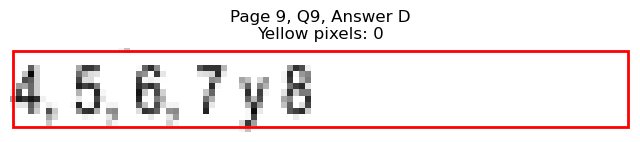


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=202.7, y1=670.1
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 710
Page 9, Q10, A: Yellow percentage: 0.0%


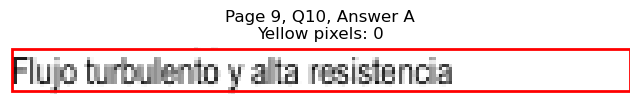

Page 9, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=289.0, y1=682.7
Page 9, Q10, B: Yellow pixels: 2
Page 9, Q10, B: Total non-white pixels: 1358
Page 9, Q10, B: Yellow percentage: 0.1%


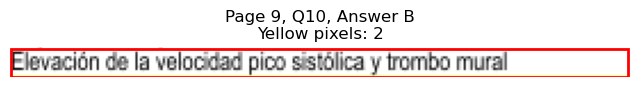

Page 9, Q10 - C: Detected box: x0=68.8, y0=682.7, x1=220.7, y1=695.3
Page 9, Q10, C: Yellow pixels: 1853
Page 9, Q10, C: Total non-white pixels: 2842
Page 9, Q10, C: Yellow percentage: 65.2%


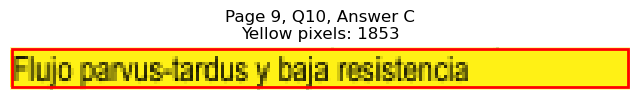

Page 9, Q10 - D: Detected box: x0=68.8, y0=695.4, x1=193.1, y1=708.0
Page 9, Q10, D: Yellow pixels: 1
Page 9, Q10, D: Total non-white pixels: 841
Page 9, Q10, D: Yellow percentage: 0.1%


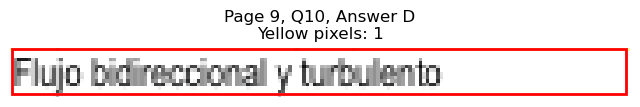


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=110.4, y1=758.4
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 215
Page 9, Q11, A: Yellow percentage: 0.0%


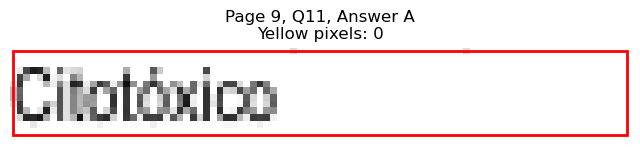

Page 9, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=111.4, y1=771.2
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 227
Page 9, Q11, B: Yellow percentage: 0.0%


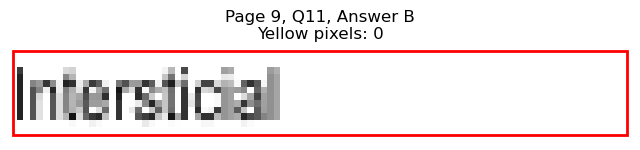

Page 9, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=377.2, y1=758.4
Page 9, Q11, C: Yellow pixels: 1112
Page 9, Q11, C: Total non-white pixels: 1414
Page 9, Q11, C: Yellow percentage: 78.6%


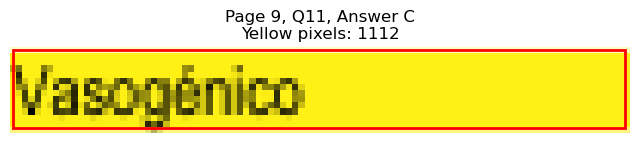

Page 9, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=378.8, y1=771.2
Page 9, Q11, D: Yellow pixels: 101
Page 9, Q11, D: Total non-white pixels: 390
Page 9, Q11, D: Yellow percentage: 25.9%


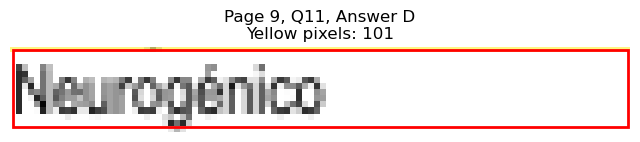


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=125.5, y1=114.7
Page 10, Q1, A: Yellow pixels: 1191
Page 10, Q1, A: Total non-white pixels: 1404
Page 10, Q1, A: Yellow percentage: 84.8%


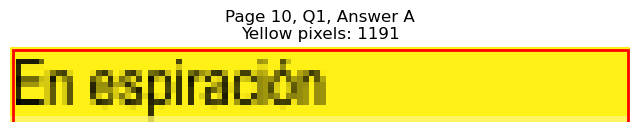

Page 10, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=127.5, y1=127.3
Page 10, Q1, B: Yellow pixels: 110
Page 10, Q1, B: Total non-white pixels: 402
Page 10, Q1, B: Yellow percentage: 27.4%


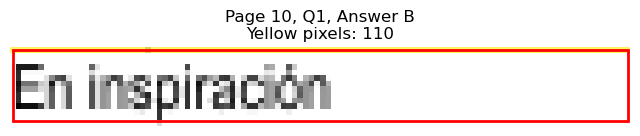

Page 10, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=456.4, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 630
Page 10, Q1, C: Yellow percentage: 0.0%


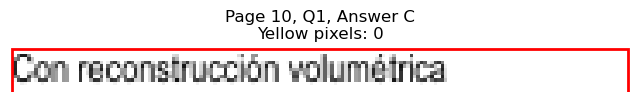

Page 10, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=379.3, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 260
Page 10, Q1, D: Yellow percentage: 0.0%


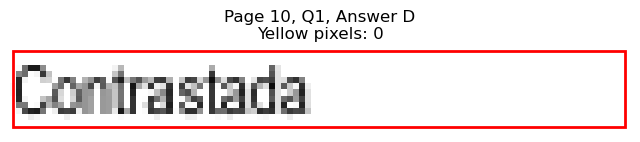


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=179.2, y1=190.4
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 545
Page 10, Q2, A: Yellow percentage: 0.0%


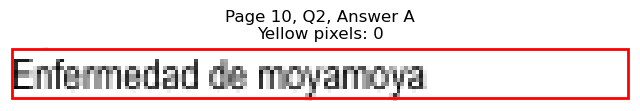

Page 10, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=168.6, y1=203.0
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 491
Page 10, Q2, B: Yellow percentage: 0.0%


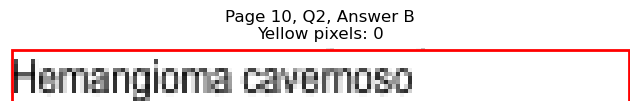

Page 10, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=397.3, y1=190.4
Page 10, Q2, C: Yellow pixels: 1199
Page 10, Q2, C: Total non-white pixels: 1694
Page 10, Q2, C: Yellow percentage: 70.8%


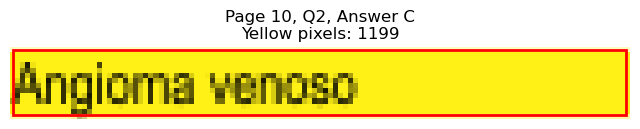

Page 10, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=441.4, y1=203.0
Page 10, Q2, D: Yellow pixels: 1
Page 10, Q2, D: Total non-white pixels: 748
Page 10, Q2, D: Yellow percentage: 0.1%


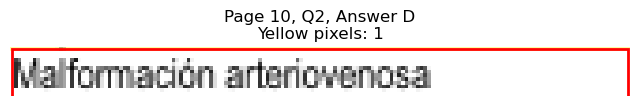


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=153.6, y1=266.1
Page 10, Q3, A: Yellow pixels: 136
Page 10, Q3, A: Total non-white pixels: 598
Page 10, Q3, A: Yellow percentage: 22.7%


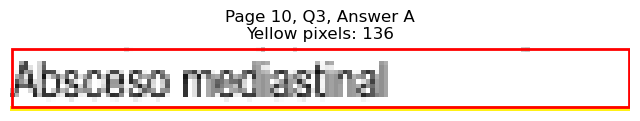

Page 10, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=148.1, y1=278.7
Page 10, Q3, B: Yellow pixels: 1359
Page 10, Q3, B: Total non-white pixels: 1703
Page 10, Q3, B: Yellow percentage: 79.8%


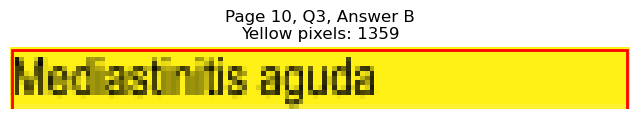

Page 10, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=402.8, y1=266.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 399
Page 10, Q3, C: Yellow percentage: 0.0%


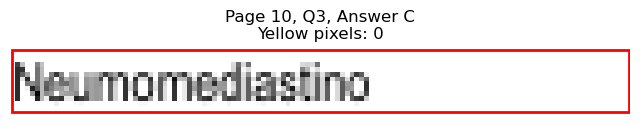

Page 10, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=397.7, y1=278.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 372
Page 10, Q3, D: Yellow percentage: 0.0%


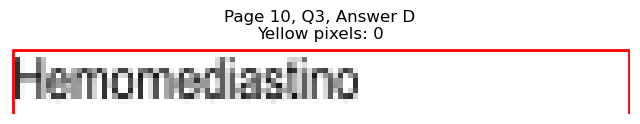


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=150.0, y1=329.3
Page 10, Q4, A: Yellow pixels: 1240
Page 10, Q4, A: Total non-white pixels: 1862
Page 10, Q4, A: Yellow percentage: 66.6%


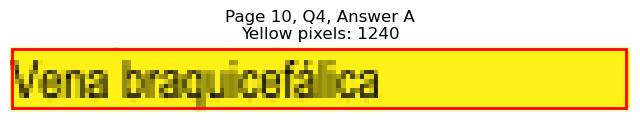

Page 10, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=146.5, y1=341.9
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 504
Page 10, Q4, B: Yellow percentage: 0.0%


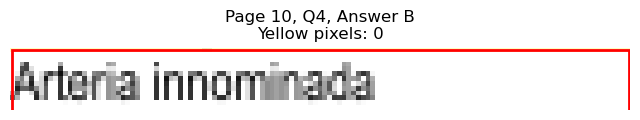

Page 10, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=403.3, y1=329.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 395
Page 10, Q4, C: Yellow percentage: 0.0%


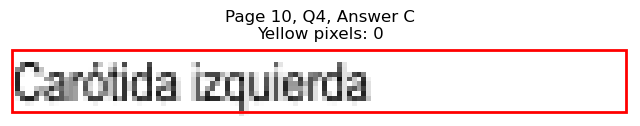

Page 10, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=407.8, y1=341.9
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 378
Page 10, Q4, D: Yellow percentage: 0.0%


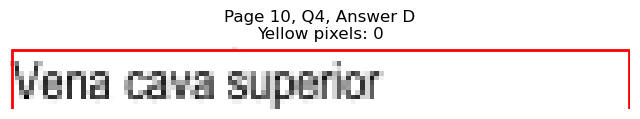


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=151.1, y1=379.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 552
Page 10, Q5, A: Yellow percentage: 0.0%


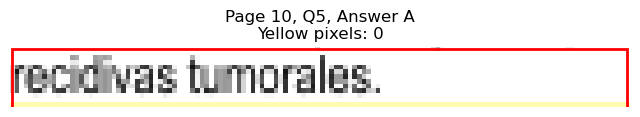

Page 10, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=173.7, y1=392.4
Page 10, Q5, B: Yellow pixels: 1510
Page 10, Q5, B: Total non-white pixels: 2184
Page 10, Q5, B: Yellow percentage: 69.1%


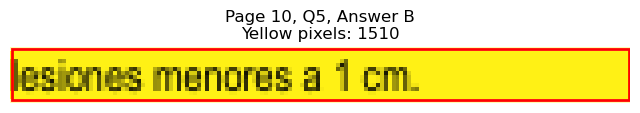

Page 10, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=403.7, y1=379.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 385
Page 10, Q5, C: Yellow percentage: 0.0%


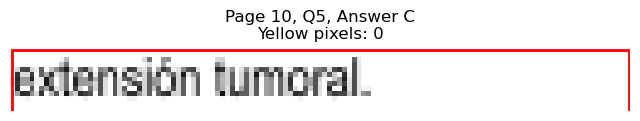

Page 10, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=429.3, y1=392.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 526
Page 10, Q5, D: Yellow percentage: 0.0%


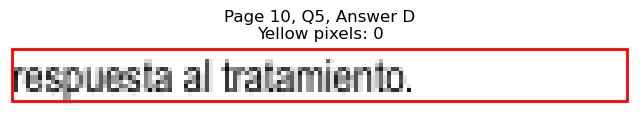


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=145.0, y1=430.3
Page 10, Q6, A: Yellow pixels: 127
Page 10, Q6, A: Total non-white pixels: 530
Page 10, Q6, A: Yellow percentage: 24.0%


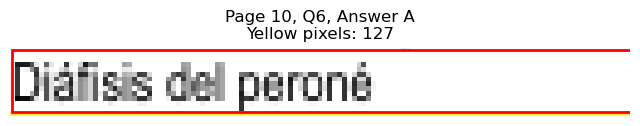

Page 10, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=162.0, y1=442.9
Page 10, Q6, B: Yellow pixels: 1519
Page 10, Q6, B: Total non-white pixels: 1885
Page 10, Q6, B: Yellow percentage: 80.6%


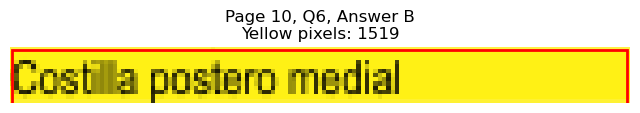

Page 10, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=396.3, y1=430.3
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 353
Page 10, Q6, C: Yellow percentage: 0.0%


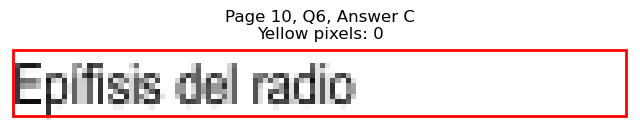

Page 10, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=411.8, y1=442.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 422
Page 10, Q6, D: Yellow percentage: 0.0%


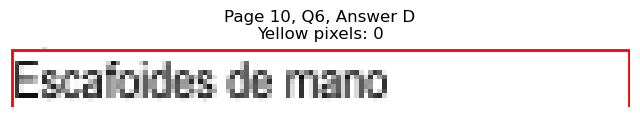


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=172.1, y1=506.0
Page 10, Q7, A: Yellow pixels: 1648
Page 10, Q7, A: Total non-white pixels: 2015
Page 10, Q7, A: Yellow percentage: 81.8%


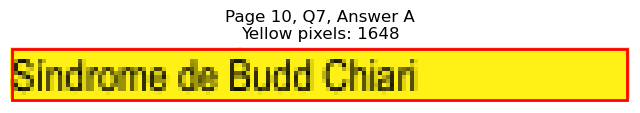

Page 10, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=138.1, y1=518.6
Page 10, Q7, B: Yellow pixels: 121
Page 10, Q7, B: Total non-white pixels: 457
Page 10, Q7, B: Yellow percentage: 26.5%


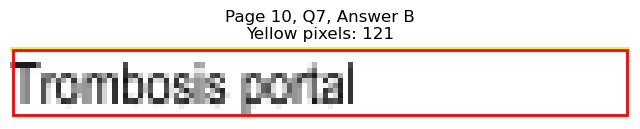

Page 10, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=432.9, y1=506.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 589
Page 10, Q7, C: Yellow percentage: 0.0%


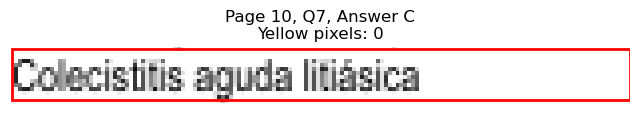

Page 10, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=399.8, y1=518.6
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 382
Page 10, Q7, D: Yellow percentage: 0.0%


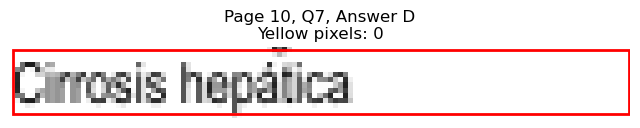


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 30 años con ingesta de alcohol frecue...
1   Niña de 7 meses con masa palpable. TC: masa re...
2   Mujer de 35 años con tos y fiebre. Rx de tórax...
3   Paciente con síndrome coronario agudo; el estu...
4   Paciente con antecedente de traumatismo abdomi...
..                                                ...
95  Mujer de 65 años, obesa, con antecedente de ci...
96  En el estudio TC del mediastino supra aórtico,...
97  En el estudio de la patología neoplásica, una ...
98  En un lactante con sospecha de maltrato infant...
99  Varón de 47 años, con antecedente de hipercoag...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       Autoinmune   
1                                        Shwannoma   
2                                         Alveolar   
3                             Descendente anterior   
4   Laceración parenquimatosa <1 cm de profundidad   
..                                             ...   
95                             Absceso mediastinal   
96                             Vena braquicefálica   
97                            recidivas tumorales.   
98                             Diáfisis del peroné   
99                         Síndrome de Budd Chiari   

                                             option_B  \
0                                             Crónica   
1                                      Fetus in fetus   
2                                           Reticular   
3                                   Coronaria derecha   
4   Laceración de 1-3 cm de profundidad y ≤10 cm d...   
..                                                ...   
95                                Mediastinitis aguda   
96                                 Arteria innominada   
97                           lesiones menores a 1 cm.   
98                            Costilla postero medial   
99                                   Trombosis portal   

                          option_C  \
0                            Aguda   
1             Linfangioma quístico   
2                Vidrio delustrado   
3                      Circunfleja   
4   Disrupción parenquimatosa >75%   
..                             ...   
95                 Neumomediastino   
96              Carótida izquierda   
97              extensión tumoral.   
98              Epífisis del radio   
99    Colecistitis aguda litiásica   

                                          option_D  
0                                        Del surco  
1                                      Liposarcoma  
2                                        Empedrado  
3                       Interventricular posterior  
4   Disrupción parenquimatosa que afecta al 25-75%  
..                                             ...  
95                                  Hemomediastino  
96                              Vena cava superior  
97                       respuesta al tratamiento.  
98                              Escafoides de mano  
99                               Cirrosis hepática  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 30 años con ingesta de alcohol frecue...   
1   Niña de 7 meses con masa palpable. TC: masa re...   
2   Mujer de 35 años con tos y fiebre. Rx de tórax...   
3   Paciente con síndrome coronario agudo; el estu...   
4   Paciente con antecedente de traumatismo abdomi...   
..                                                ...   
95  Mujer de 65 años, obesa, con antecedente de ci...   
96  En el estudio TC del mediastino supra aórtico,...   
97  En el estudio de la patología neoplásica, una ...   
98  En un lactante con sospecha de maltrato infant...   
99  Varón de 47 años, con antecedente de hipercoag...   

                                          option_A  \
0                                       Autoinmune   
1                                        Shwannoma   
2                                         Alveolar   
3                             Descendente anterior   
4   Laceración parenquimatosa <1 cm de profundidad   
..                                             ...   
95                             Absceso mediastinal   
96                             Vena braquicefálica   
97                            recidivas tumorales.   
98                             Diáfisis del peroné   
99                         Síndrome de Budd Chiari   

                                             option_B  \
0                                             Crónica   
1                                      Fetus in fetus   
2                                           Reticular   
3                                   Coronaria derecha   
4   Laceración de 1-3 cm de profundidad y ≤10 cm d...   
..                                                ...   
95                                Mediastinitis aguda   
96                                 Arteria innominada   
97                           lesiones menores a 1 cm.   
98                            Costilla postero medial   
99                                   Trombosis portal   

                          option_C  \
0                            Aguda   
1             Linfangioma quístico   
2                Vidrio delustrado   
3                      Circunfleja   
4   Disrupción parenquimatosa >75%   
..                             ...   
95                 Neumomediastino   
96              Carótida izquierda   
97              extensión tumoral.   
98              Epífisis del radio   
99    Colecistitis aguda litiásica   

                                          option_D correct_answer  
0                                        Del surco              B  
1                                      Liposarcoma              B  
2                                        Empedrado              A  
3                       Interventricular posterior              A  
4   Disrupción parenquimatosa que afecta al 25-75%              D  
..                                             ...            ...  
95                                  Hemomediastino              B  
96                              Vena cava superior              A  
97                       respuesta al tratamiento.              B  
98                              Escafoides de mano              B  
99                               Cirrosis hepática              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/RADIOLOGÍA.csv
